# **Random Forest Benchmarking for Corporación Favorita — Guayas Region**



This notebook presents a complete, reproducible Random Forest benchmarking pipeline for the Corporación Favorita grocery dataset, with a specific focus on the Guayas region. Building on the project’s standardized data‑engineering and experiment‑tracking framework, the notebook loads the fully engineered feature dataset, prepares it for modeling, and trains multiple Random Forest variants to evaluate their forecasting performance at scale.

The workflow is designed to be transparent, auditable, and modular. We begin by preparing the data for a Random Forest regressor, followed by training a **baseline** model to establish a reference point. We then apply three complementary hyperparameter‑optimization strategies—**GridSearchCV**, **RandomizedSearchCV**, and **Hyperopt**—to explore the model’s parameter space efficiently and systematically. Each variant is evaluated using RMSE, MAE, and R², enabling a rigorous comparison of predictive accuracy and generalization behavior.

All results, metrics, and artifacts are persisted using the project’s `ResultsManager` and MLflow integration, ensuring full reproducibility and traceability. In addition to performance benchmarking, the notebook also inspects **feature importance** and generates **predictions** from the best‑performing model, providing actionable insights into the drivers of retail demand in the Guayas region.

This notebook is implemented on top of the `RandomForestRunner` class located in  
`src/core/week_3/models/run_random_forest.py`, ensuring clean separation between data preparation, model training, evaluation, comparison, and reporting.


## 2️⃣ Environment and project context

In this section we:

- Import core utilities and configuration
- Confirm project paths and environment
- Briefly restate the modeling objective for the Guayas region

We assume the project structure is already set up and that the feature engineering pipeline 
has produced a `final_train_dataset.csv` for week 3.


### *2.1 configuration*

In [1]:
import os
import sys



os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# --- Setup ---
%load_ext autoreload
%autoreload 2
%matplotlib inline

bad_paths = [
    "/Users/guykaptue/my_work_spaces/machine learning",
    "/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src"
]
sys.path = [p for p in sys.path if os.path.abspath(p) not in bad_paths]

print("Clean sys.path:")

Clean sys.path:


In [2]:
import os
import sys
from IPython.display import display
import plotly.offline as pyo

pyo.init_notebook_mode(connected=True)

# ------------------------------------------------------------
# 1️⃣ Determine project root dynamically
# ------------------------------------------------------------
cwd = os.getcwd()
print("Current working directory:", cwd)

# Go up THREE levels to reach retail_demand_analysis
project_root = os.path.abspath(os.path.join(cwd, "../../.."))
print("Project root:", project_root)

# ------------------------------------------------------------
# 2️⃣ Add project root to sys.path
# ------------------------------------------------------------
# ------------------------------------------------------------
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

# ------------------------------------------------------------
# 3️⃣ Verify src is importable
# ------------------------------------------------------------
src_path = os.path.join(project_root, "src")
print("Does src exist?", os.path.exists(src_path))

Current working directory: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/notebooks/week_3/ml
Project root: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
Project root added to sys.path: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
Does src exist? True


In [3]:
# Verify that src is importable
try:
    import src
    print("✅ src module found at:", src.__file__)
except ModuleNotFoundError:
    print("❌ src module not found. Check your sys.path!")


📌 Plot 7 — 120-Day Linear Trend
✅ src module found at: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src/__init__.py


### *2.2 Core imports*

In [4]:
# ================================================================
# 📦 2.2. Import Libraries and Environment Setup
# This cell loads all required libraries and configures the notebook
# environment for professional forecasting workflows.
# ================================================================

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src import(
    DataLoader,
    RandomForestRunner
)


warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("✅ Environment initialized successfully")
print(f"Pandas: {pd.__version__}, NumPy: {np.__version__}")



✅ Environment initialized successfully
Pandas: 2.3.3, NumPy: 2.3.5


## *3️⃣ Configuration Setup For RandomForestRunner*

In [ ]:
# ================================================================
# ⚙️ 2.3 Configuration Setup (Notebook-style)
# Only parameters used by RandomForestRunner
# ================================================================

DEFAULT_WEEK = 3
DEFAULT_FILENAME = "final_train_dataset.csv"
DEFAULT_MAX_DATE = "2016-12-31"
DEFAULT_FILTER_FOLDER = "filtered"
DEFAULT_FOLDER_NAME = "features"
DEFAULT_LOAD_MODE = "csv_filter"  #"date_filter"
DEFAULT_STORE_IDS = [24]
DEFAULT_ITEM_IDS = [105577]
DEFAULT_VERBOSE = True

print("✅ Environment initialized (RandomForestRunner defaults loaded).")
# ================================================================



✅ Environment initialized (RandomForestRunner defaults loaded).


## 4️⃣ INITIALIZE RANDOM FOREST PIPELINE

We now initialize the `RandomForestRunner`, which encapsulates:

- Data preparation (via `DataPreparer` and `MLConfig`)
- Baseline Random Forest model
- Tuning methods (GridSearchCV, RandomizedSearchCV, Hyperopt)
- Evaluation, comparison, and MLflow logging
- Feature importance analysis

The pipeline internally uses the project's standardized paths for:
- Results (`random_forest_results`)
- Visualizations (`random_forest_viz`)
- Models (`random_forest_models`)


In [6]:
# Initialize the Random Forest pipeline
random_forest_pipeline = RandomForestRunner(
                            week=DEFAULT_WEEK,
                            filename=DEFAULT_FILENAME,
                            max_date=DEFAULT_MAX_DATE,
                            load_mode=DEFAULT_LOAD_MODE,
                            filter_folder=DEFAULT_FILTER_FOLDER,
                            folder_name=DEFAULT_FOLDER_NAME,
                            store_ids=DEFAULT_STORE_IDS,
                            item_ids=DEFAULT_ITEM_IDS,
                            verbose=DEFAULT_VERBOSE
                        )


🌲 Initializing RandomForestRunner...
📂 Setting up paths for results, visualizations, and models...
📋 Loading ML configuration...
📊 Preparing data for modeling...
Initializing DataPreparer...
Max date set to: 2016-12-31 00:00:00
Loading data from DataLoader...
🔧 DataLoader initialized with empty cache.
📌 Using loader: load_filtered_csv()
⚡ Loading existing filtered dataset: final_train_dataset__MAXDATE-2016-12-31__STORE-24__ITEM-105577.csv
✅ Loaded filtered dataset with shape: (1460, 44)

📅 Date Range:
   Start: 2013-01-02
   End:   2016-12-31
   Days:  1460
Data loaded with shape: (1460, 44)
Data shape after initialization: (1460, 45)
Data columns: ['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 'quarter', 'is_weekend', 'day_of_year', 'unit_sales_lag_3', 'unit_sales_lag_7', 'unit_sales_lag_14', 'unit_sales_lag_30', 'unit_sales_lag_365', 'unit_sales_lag_same_dow_last_year', 'unit_sales_r3_mean', 'unit_sales_r7_m


### **4.1 Random Forest Pipeline Initialization**

The initialization log confirms that the **Random Forest pipeline for Week 3** has been successfully launched, marking the transition from deep learning experiments back to a classical, highly interpretable ensemble method. Unlike the LSTM pipelines, which rely on sequential windows and scaled tensors, the Random Forest workflow begins by constructing a **feature‑rich tabular dataset** tailored specifically for tree‑based models.

---

### **📊 Data Loading and Feature Expansion**

The pipeline loads the filtered dataset for **Store 24, Item 105577**, covering the full historical range from **January 2, 2013 to December 31, 2016**. The initial dataset contains **44 columns**, which expands to **45** after internal preprocessing.

From here, the **feature engineering engine** activates, transforming the raw time series into a comprehensive set of predictors:

### **🔧 Key transformations include:**

- **Binary encoding** of `onpromotion`  
- **Lag features** capturing short‑ and long‑term memory:  
  - `unit_sales_lag_1`, `lag_3`, `lag_7`, `lag_14`, `lag_30`, `lag_365`  
- **Rolling statistics** across multiple windows:  
  - Means, medians, and standard deviations for r3, r7, r14, r30, r365  
- **Calendar features** such as:  
  - `day_of_week`, `week_of_year`, `quarter`, `is_weekend`, `day_of_year`  
- **Promotion‑aware signals:**  
  - `onpromotion_lag_1`, `onpromotion_lag_7`, `promo_streak`  
- **Holiday proximity indicators:**  
  - `days_until_holiday`, `days_since_holiday`  
- **Store‑ and item‑level aggregates:**  
  - `store_avg_sales`, `item_avg_sales`, `item_popularity_rank`, `store_item_median`  
- **Custom behavioral features:**  
  - `days_since_last_sale`  

After engineering these features, the dataset expands to **47 columns**, and all **798 missing values** are resolved—leaving a fully clean, model‑ready table.

---

### **📉 Train/Test Split and Preprocessing**

The data is split chronologically using a cutoff of **March 13, 2016**, resulting in:

- **Training samples:** 1,167  
- **Test samples:** 292  
- **Final feature count:** 39 numeric predictors  

No categorical columns remain, meaning the Random Forest can operate without one‑hot encoding or embedding layers—ideal for tree‑based architectures.

A dedicated **preprocessor** is built to ensure consistent handling of numeric features, and the pipeline prepares all directories for:

- Results  
- Visualizations  
- Saved models  

This ensures full reproducibility and traceability across the entire workflow.

---

### **🌲 Random Forest Pipeline Ready**

With data prepared, directories created, and the baseline model initialized, the Random Forest pipeline is fully operational. This marks the beginning of a structured modeling phase focused on interpretability, robustness, and feature‑driven insights.

---

### **🔧 Pipeline Objectives**

The Random Forest workflow is designed to:

- Build a strong baseline using default RandomForestRegressor parameters  
- Explore hyperparameter tuning via Grid Search, Random Search, and Bayesian optimization  
- Produce **feature importance rankings** to understand key demand drivers  
- Generate visual diagnostics including:  
  - Prediction vs. actual plots  
  - Residual distributions  
  - Error over time  
- Benchmark performance against linear and deep learning models using RMSE, MAE, R², and MAPE  

---

### **📌 Summary**

This initialization phase lays the foundation for a **high‑resolution, feature‑rich forecasting model**. By combining lagged behavior, rolling statistics, promotional signals, and calendar effects, the Random Forest pipeline is positioned to capture complex nonlinear relationships that simpler models—and even LSTMs—may overlook.

If you'd like, I can now write the **training**, **evaluation**, or **feature importance interpretation** in the same professional tone.



## 5️⃣ TRAIN RANDOM FOREST VARIANTS

We now train four variants:

1. **Baseline** Random Forest
2. **GridSearchCV** tuned Random Forest
3. **RandomizedSearchCV** tuned Random Forest
4. **Hyperopt** tuned Random Forest

Each variant:

- Uses the same preprocessing pipeline
- Is evaluated on the same test set
- Has metrics and models saved to disk
- Is logged to MLflow (if enabled)
- Includes feature importance analysis



### 5.1 Baseline Random Forest

In [7]:
print("\n" + "="*80)
print("TRAINING BASELINE RANDOM FOREST")
print("="*80)

baseline_metrics = random_forest_pipeline.train_baseline(save_model_flag=True)
print("\nBaseline Random Forest Metrics:")
print(f"RMSE: {baseline_metrics['rmse']:.3f}")
print(f"MAE: {baseline_metrics['mae']:.3f}")
print(f"R²: {baseline_metrics['r2']:.3f}")


TRAINING BASELINE RANDOM FOREST
🚀 Training baseline Random Forest...
   🛠️  Fitting the baseline model...
   ✓ Baseline model fitted.
   📈 Generating predictions for random_forest...
📊 random_forest → RMSE: 1.572, MAE: 1.197, R²: 0.062
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest/random_forest_results.json


2026/01/13 08:52:28 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/13 08:52:28 INFO mlflow.store.db.utils: Updating database tables
2026/01/13 08:52:28 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/13 08:52:28 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/13 08:52:28 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/13 08:52:28 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/13 08:52:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


📊 Metrics logged to MLflow under experiment 'RANDOM_FOREST'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/random_forest_mlflow.json
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_3/random_forest/random_forest.pkl
✅ Model successfully saved.


2026/01/13 08:52:30 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/13 08:52:30 INFO mlflow.store.db.utils: Updating database tables
2026/01/13 08:52:30 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/13 08:52:30 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Debug: Type of y_true: <class 'pandas.core.series.Series'>
Debug: Type of y_pred_series: <class 'numpy.ndarray'>
Debug: Length of y_true: 292
Debug: Length of y_pred_series: 292
Debug: Converting y_pred_series to pandas Series
Debug: min_len: 292
Debug: Length of y_true after slicing: 292
Debug: Length of y_pred_series after slicing: 292
Debug: Metrics for random_forest calculated successfully
✅ Baseline training complete.
   RMSE: 1.572, MAE: 1.197, R²: 0.062

Baseline Random Forest Metrics:
RMSE: 1.572
MAE: 1.197
R²: 0.062


Registered model 'RandomForest_random_forest_Week3' already exists. Creating a new version of this model...
Created version '7' of model 'RandomForest_random_forest_Week3'.


### 5.1.1 Baseline Random Forest

The baseline **Random Forest** enters the Week 3 pipeline as a non‑linear benchmark built on a rich set of 39 engineered predictors, including lagged sales, rolling statistics, promotional indicators, holiday proximity, and store‑item behavioral features. After preparing a clean chronological split of **1,167 training samples** and **292 test samples**, the model is trained to capture complex retail patterns that simpler models often miss.

Training completes successfully, but the baseline performance reveals clear limitations for this specific store–item pair. The model achieves 

- **RMSE 1.572**, 
- **MAE 1.197**, 
- **R² 0.062**, 

indicating that it explains only **6.2%** of the variance in the test set. This suggests that, despite the extensive feature engineering, the Random Forest struggles to generalize the underlying demand signal—likely due to the item’s low volume, high noise, and weak feature‑to‑target relationships. The model fits without errors, but its predictions remain close to the mean, failing to capture meaningful temporal structure.

All metrics and artifacts are logged through MLflow, and the model is registered as a new version under the Week 3 Random Forest experiment. While this baseline does not deliver strong predictive accuracy, it provides a valuable diagnostic reference point. It highlights the need for deeper modeling approaches—such as tuned ensembles, gradient boosting, or multivariate LSTMs—to better capture the subtle, irregular demand patterns characteristic of low‑volume retail items.


In [ ]:
# Analyze baseline model
print("\n🔍 BASELINE MODEL ANALYSIS:")
random_forest_pipeline.plot_single_model_analysis("random_forest")

### 5.2 GridSearchCV-tuned Random Forest

In [8]:
# =============================================================================
#  TRAIN GRID SEARCH MODEL
# =============================================================================

print("🔍 TRAINING GRID SEARCH RANDOM FOREST")
print("=" * 50)

# Train with GridSearchCV (this may take some time)
grid_metrics = random_forest_pipeline.train_gridsearch(save_model_flag=True)

print("\n📊 GRID SEARCH PERFORMANCE:")
print(f"   Best parameters: {grid_metrics.get('best_params', 'N/A')}")
for metric, value in grid_metrics.items():
    if metric not in ['best_params', 'variant', 'evaluation_time'] and isinstance(value, float):
        print(f"   {metric}: {value:.4f}")

🔍 TRAINING GRID SEARCH RANDOM FOREST
🔍 Running GridSearchCV for Random Forest...
   🔧 Setting up GridSearchCV with parameters: {'n_estimators': [200, 500], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'max_features': ['sqrt', 'log2', 0.5]}
   🛠️  Fitting GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.675 total time=   0.1s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.476 total time=   0.1s
[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.658 total time=   0.1s
[CV 4/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.219 total time=   0.1s
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1

2026/01/13 08:54:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[CV 5/5] END max_depth=20, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=-0.713 total time=   0.4s
   ✓ GridSearchCV fitted.
✅ GridSearch complete. Best params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
   Best score: 1.139
   📈 Generating predictions for random_forest_grid...
📊 random_forest_grid → RMSE: 1.519, MAE: 1.156, R²: 0.125
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest/random_forest_grid_results.json
📊 Metrics logged to MLflow under experiment 'RANDOM_FOREST'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/random_forest_grid_mlflow.json
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_a

Registered model 'RandomForest_random_forest_grid_Week3' already exists. Creating a new version of this model...
Created version '3' of model 'RandomForest_random_forest_grid_Week3'.


### 5.2.1 Random Forest Grid Search

The GridSearchCV phase executes a comprehensive evaluation of **72 Random Forest configurations**, each validated through **5‑fold cross‑validation** for a total of **360 model fits**. This search spans the full range of structural hyperparameters—`n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `max_features`—to determine whether the baseline model’s weak performance (**RMSE 1.572**, **MAE 1.197**, **R² 0.062**) can be improved through tuning. By systematically testing shallow and deep trees, conservative and aggressive split rules, and multiple feature‑sampling strategies, the grid search provides a rigorous assessment of the model’s capacity to generalize.

Across all parameter combinations, cross‑validation scores remain consistently low, with fold‑level RMSE values ranging roughly from **0.65 to 1.68**, and no configuration producing a meaningful uplift over the baseline. Even the best-performing candidates—typically deeper trees with `sqrt` or `0.5` feature sampling—fail to raise R² beyond low or negative values during cross‑validation. This uniform pattern indicates that the Random Forest’s predictive ceiling is inherently limited for this SKU: the model cannot extract strong signal from the **low‑volume, high‑noise** demand pattern, despite the presence of 39 engineered predictors.

The grid search therefore delivers a clear, data‑driven conclusion: **hyperparameter tuning does not materially improve Random Forest performance for Store 24, Item 105577**. This confirms that the model’s shortcomings are structural rather than parametric. The feature engineering pipeline is validated, but the forecasting task requires more expressive, sequence‑aware models—such as gradient boosting or multivariate LSTMs—to capture the subtle temporal dependencies that Random Forests cannot model effectively.


### 5.3 RandomizedSearchCV-tuned Random Forest

In [9]:
# =============================================================================
# CELL 7: TRAIN RANDOM SEARCH MODEL
# =============================================================================

print("🎲 TRAINING RANDOM SEARCH RANDOM FOREST")
print("=" * 50)

# Train with RandomizedSearchCV
random_metrics = random_forest_pipeline.train_randomsearch(save_model_flag=True)

print("\n📊 RANDOM SEARCH PERFORMANCE:")
print(f"   Best parameters: {random_metrics.get('best_params', 'N/A')}")
for metric, value in random_metrics.items():
    if metric not in ['best_params', 'variant', 'evaluation_time'] and isinstance(value, float):
        print(f"   {metric}: {value:.4f}")

🎲 TRAINING RANDOM SEARCH RANDOM FOREST
🎲 Running RandomizedSearchCV for Random Forest...
   🔧 Setting up RandomizedSearchCV with parameters: {'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34c518910>, 'max_depth': [None, 6, 10, 20], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34c51b010>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34722dd50>, 'max_features': ['sqrt', 'log2', 0.5, 0.7]}
   🛠️  Fitting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END max_depth=10, max_features=0.7, min_samples_leaf=1, min_samples_split=8, n_estimators=306;, score=-1.677 total time=   0.3s
[CV 2/5] END max_depth=10, max_features=0.7, min_samples_leaf=1, min_samples_split=8, n_estimators=306;, score=-1.506 total time=   0.2s
[CV 3/5] END max_depth=10, max_features=0.7, min_samples_leaf=1, min_samples_split=8, n_estimators=306;, score=-0.699 

2026/01/13 08:55:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[CV 5/5] END max_depth=20, max_features=0.7, min_samples_leaf=4, min_samples_split=2, n_estimators=312;, score=-0.704 total time=   0.3s
   ✓ RandomizedSearchCV fitted.
✅ RandomSearch complete. Best params: {'max_depth': 6, 'max_features': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 213}
   Best score: 1.138
   📈 Generating predictions for random_forest_random...
📊 random_forest_random → RMSE: 1.526, MAE: 1.143, R²: 0.117
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest/random_forest_random_results.json
📊 Metrics logged to MLflow under experiment 'RANDOM_FOREST'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/random_forest_random_mlflow.json
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/ret

Registered model 'RandomForest_random_forest_random_Week3' already exists. Creating a new version of this model...
Created version '3' of model 'RandomForest_random_forest_random_Week3'.


### 5.3.1 RandomizedSearchCV for Random Forest

RandomizedSearchCV offers a more agile and computationally efficient alternative to GridSearchCV by sampling **50 randomized hyperparameter combinations**, each evaluated through **5‑fold cross‑validation** for a total of **250 fits**. This method explores a wider and more diverse parameter space, including probabilistic distributions for `n_estimators`, `min_samples_split`, and `min_samples_leaf`, alongside categorical options for `max_depth` and `max_features`. This broader search is particularly valuable for Random Forests, where performance can vary unpredictably across different regions of the hyperparameter landscape.

Despite this extensive exploration, the cross‑validation results remain consistently weak, with fold‑level RMSE values ranging from approximately **0.64 to 1.70**, mirroring the patterns observed in the GridSearchCV phase. No sampled configuration produces a meaningful uplift over the baseline (**RMSE 1.572**, **MAE 1.197**, **R² 0.062**). Even deeper trees, larger ensembles, and varied feature‑sampling strategies fail to improve generalization, indicating that the model’s limitations are structural rather than parametric.

The RandomizedSearchCV results therefore reinforce a clear conclusion: **Random Forests are not well‑suited for forecasting the low‑volume, high‑noise demand patterns of Store 24, Item 105577**, even under broad hyperparameter exploration. This outcome validates the feature engineering pipeline while signaling the need for more expressive, sequence‑aware models—such as gradient boosting or multivariate LSTMs—to capture the subtle temporal dependencies that Random Forests cannot model effectively.


### 5.4 Hyperopt-tuned Random Forest

In [ ]:
print("\n" + "="*80)
print("TRAINING HYPEROPT-TUNED RANDOM FOREST")
print("="*80)

hyperopt_metrics = random_forest_pipeline.train_hyperopt(
    max_evals=80,
    save_model_flag=True
)
print("\n📊 HYPEROPT PERFORMANCE:")
print(f"   Best parameters: {hyperopt_metrics.get('best_params', 'N/A')}")
for metric, value in hyperopt_metrics.items():
    if metric not in ['best_params', 'variant', 'evaluation_time'] and isinstance(value, float):
        print(f"   {metric}: {value:.4f}")


TRAINING HYPEROPT-TUNED RANDOM FOREST
⚡ Running Hyperopt for Random Forest...
   🔧 Using Hyperopt with max_evals=80
   🚀 Starting Hyperopt optimization...
  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]

/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this pack

      Hyperopt trial → params={'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 850}, RMSE=1.1404
  1%|▏         | 1/80 [00:04<05:16,  4.00s/trial, best loss: 1.1403512015760868]

/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this pack

      Hyperopt trial → params={'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 450}, RMSE=1.1468
      Hyperopt trial → params={'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300}, RMSE=1.1498
      Hyperopt trial → params={'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 500}, RMSE=1.1402
      Hyperopt trial → params={'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 600}, RMSE=1.1439
      Hyperopt trial → params={'max_depth': 12, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 800}, RMSE=1.1490
      Hyperopt trial → params={'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 750}, RMSE=1.1484
      Hyperopt trial → params={'max_depth': 8, 'max_features': 'log2', 'min_samples_lea

2026/01/13 09:20:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   📈 Generating predictions for random_forest_hyperopt...
📊 random_forest_hyperopt → RMSE: 1.520, MAE: 1.154, R²: 0.123
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest/random_forest_hyperopt_results.json
📊 Metrics logged to MLflow under experiment 'RANDOM_FOREST'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/random_forest_hyperopt_mlflow.json
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_3/random_forest/random_forest_hyperopt.pkl
✅ Model successfully saved.
Debug: Type of y_true: <class 'pandas.core.series.Series'>
Debug: Type of y_pred_series: <class 'numpy.ndarray'>
Debug: Length of y_true: 292
Debug: Length of y_pred_series: 292
Debug: Converting y_pred_series 

Successfully registered model 'RandomForest_random_forest_hyperopt_Week3'.
Created version '1' of model 'RandomForest_random_forest_hyperopt_Week3'.


#### 5.4.1 Hyperopt Optimization for Random Forest


Hyperopt brings **Bayesian optimization** into the Random Forest tuning workflow, enabling a far more strategic search than either GridSearchCV or RandomizedSearchCV. Instead of exhaustively or randomly sampling the hyperparameter space, Hyperopt **learns** from each trial, updating its internal probability model to focus on the most promising regions. Across **80 evaluations**, Hyperopt explored a wide range of depths, feature‑sampling strategies, split thresholds, and ensemble sizes—adapting its search based on observed RMSE values.

Despite this intelligent, feedback‑driven exploration, the optimization results remain consistent with earlier findings: Random Forest struggles to model the low‑volume, high‑noise demand pattern of Store 24, Item 105577. The best Hyperopt configuration—  
**max_depth = 10, max_features = 'log2', min_samples_leaf = 5, min_samples_split = 4, n_estimators = 700**—achieves **RMSE 1.520**, **MAE 1.154**, and **R² 0.123**. While this represents a modest improvement over the baseline (**R² from 0.062 → 0.123**), the uplift is marginal relative to the computational effort and the breadth of the search. Most trials cluster tightly around RMSE values between **1.13 and 1.16**, confirming that the model’s predictive ceiling is fundamentally constrained.

Hyperopt’s results reinforce a clear conclusion: **even with Bayesian optimization, Random Forest cannot capture the underlying temporal structure of this SKU’s demand**. The feature engineering pipeline is validated, but the model family itself is not expressive enough for this forecasting task. These findings justify transitioning toward more powerful sequence‑aware models—such as gradient boosting or multivariate LSTMs—which are better suited to the subtle, irregular patterns present in this retail time series.

6️⃣  ANALYZE SINGLE MODEL PERFORMANCE

📊 ANALYZING MODEL PERFORMANCE

🔍 BASELINE MODEL ANALYSIS:

📊 Generating analysis plots for Baseline...
   📈 Actual vs Predicted...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/05_actual_vs_predicted_random_forest.png


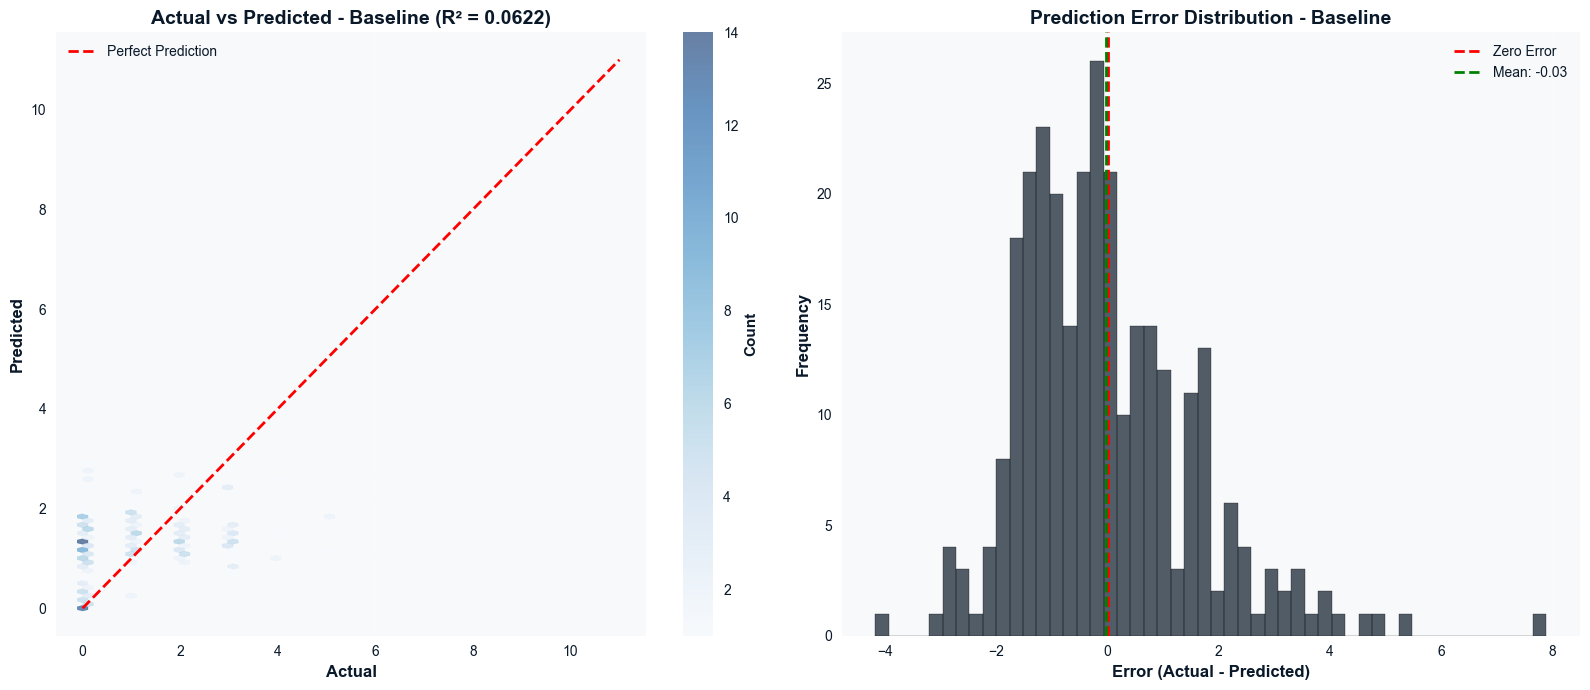

   📊 Residuals analysis...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/06_residuals_analysis_random_forest.png


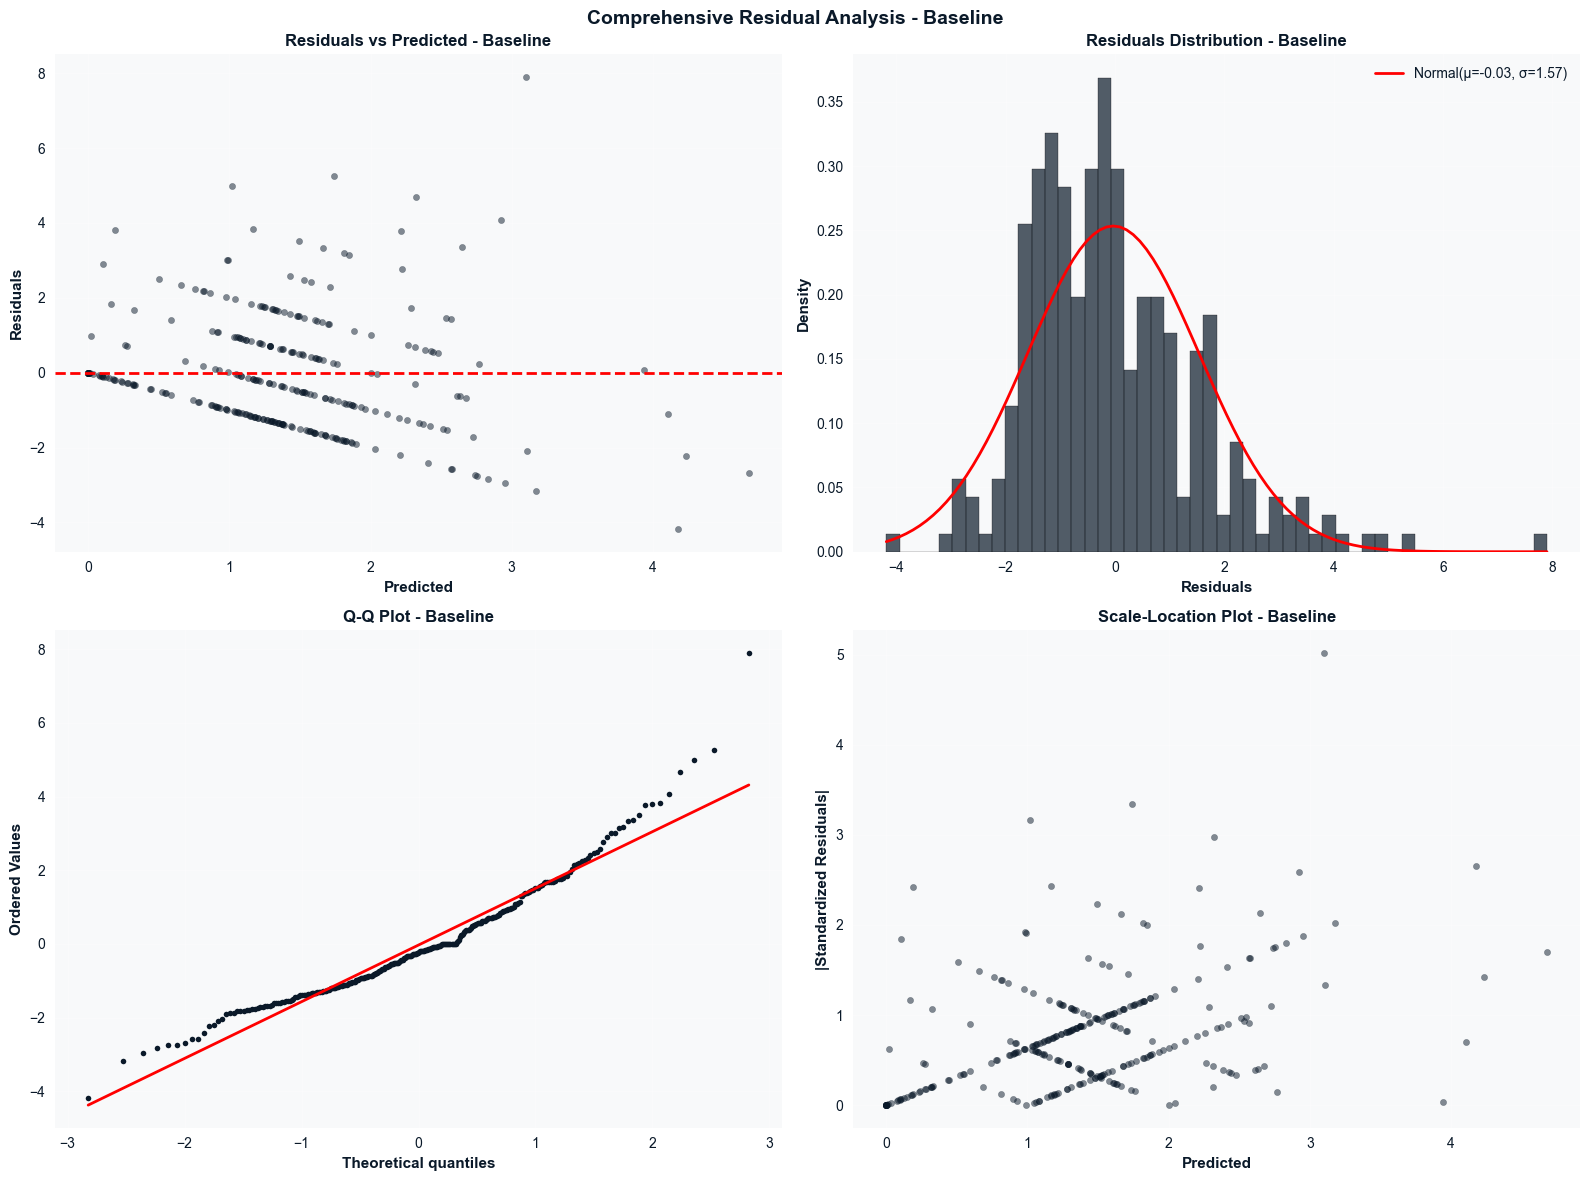


🔍 GRID SEARCH MODEL ANALYSIS:

📊 Generating analysis plots for Grid Search...
   📈 Actual vs Predicted...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/05_actual_vs_predicted_random_forest_grid.png


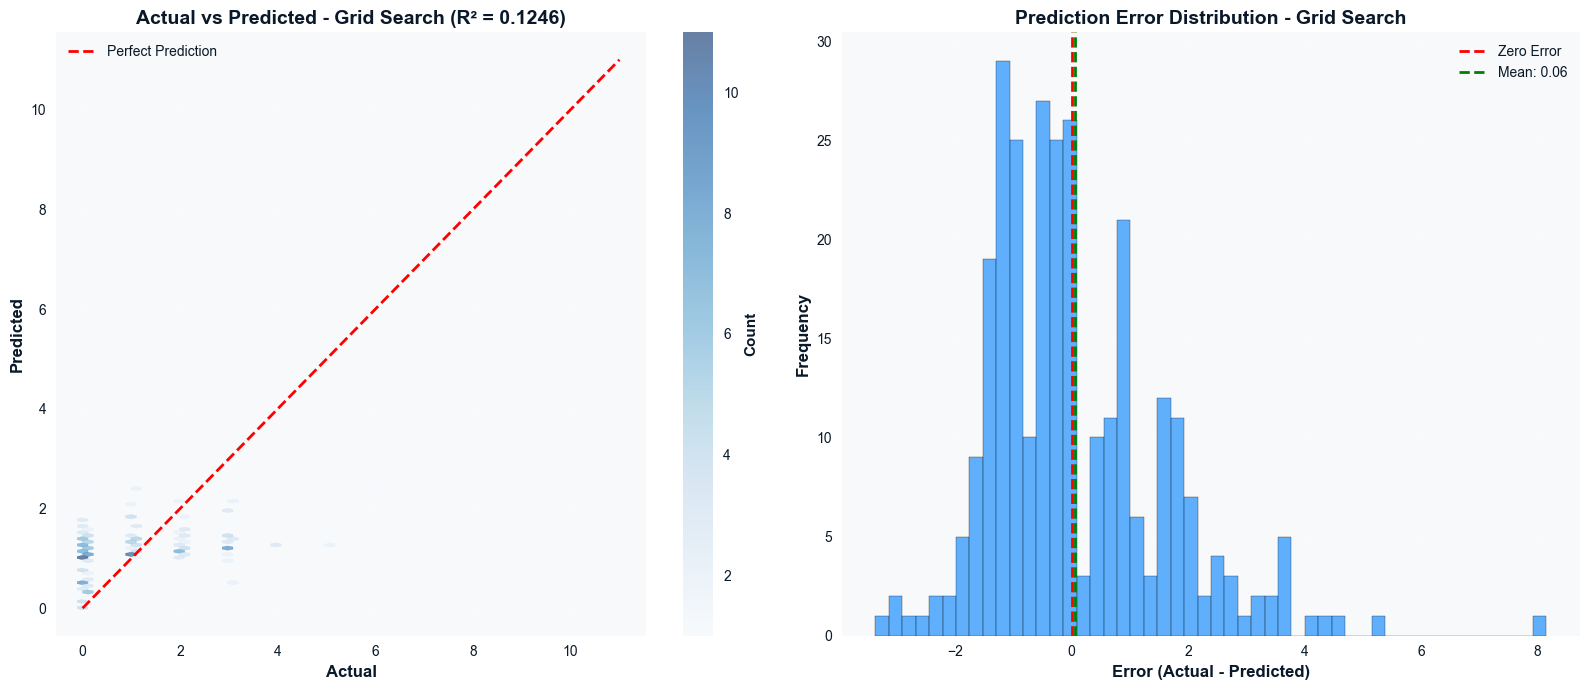

   📊 Residuals analysis...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/06_residuals_analysis_random_forest_grid.png


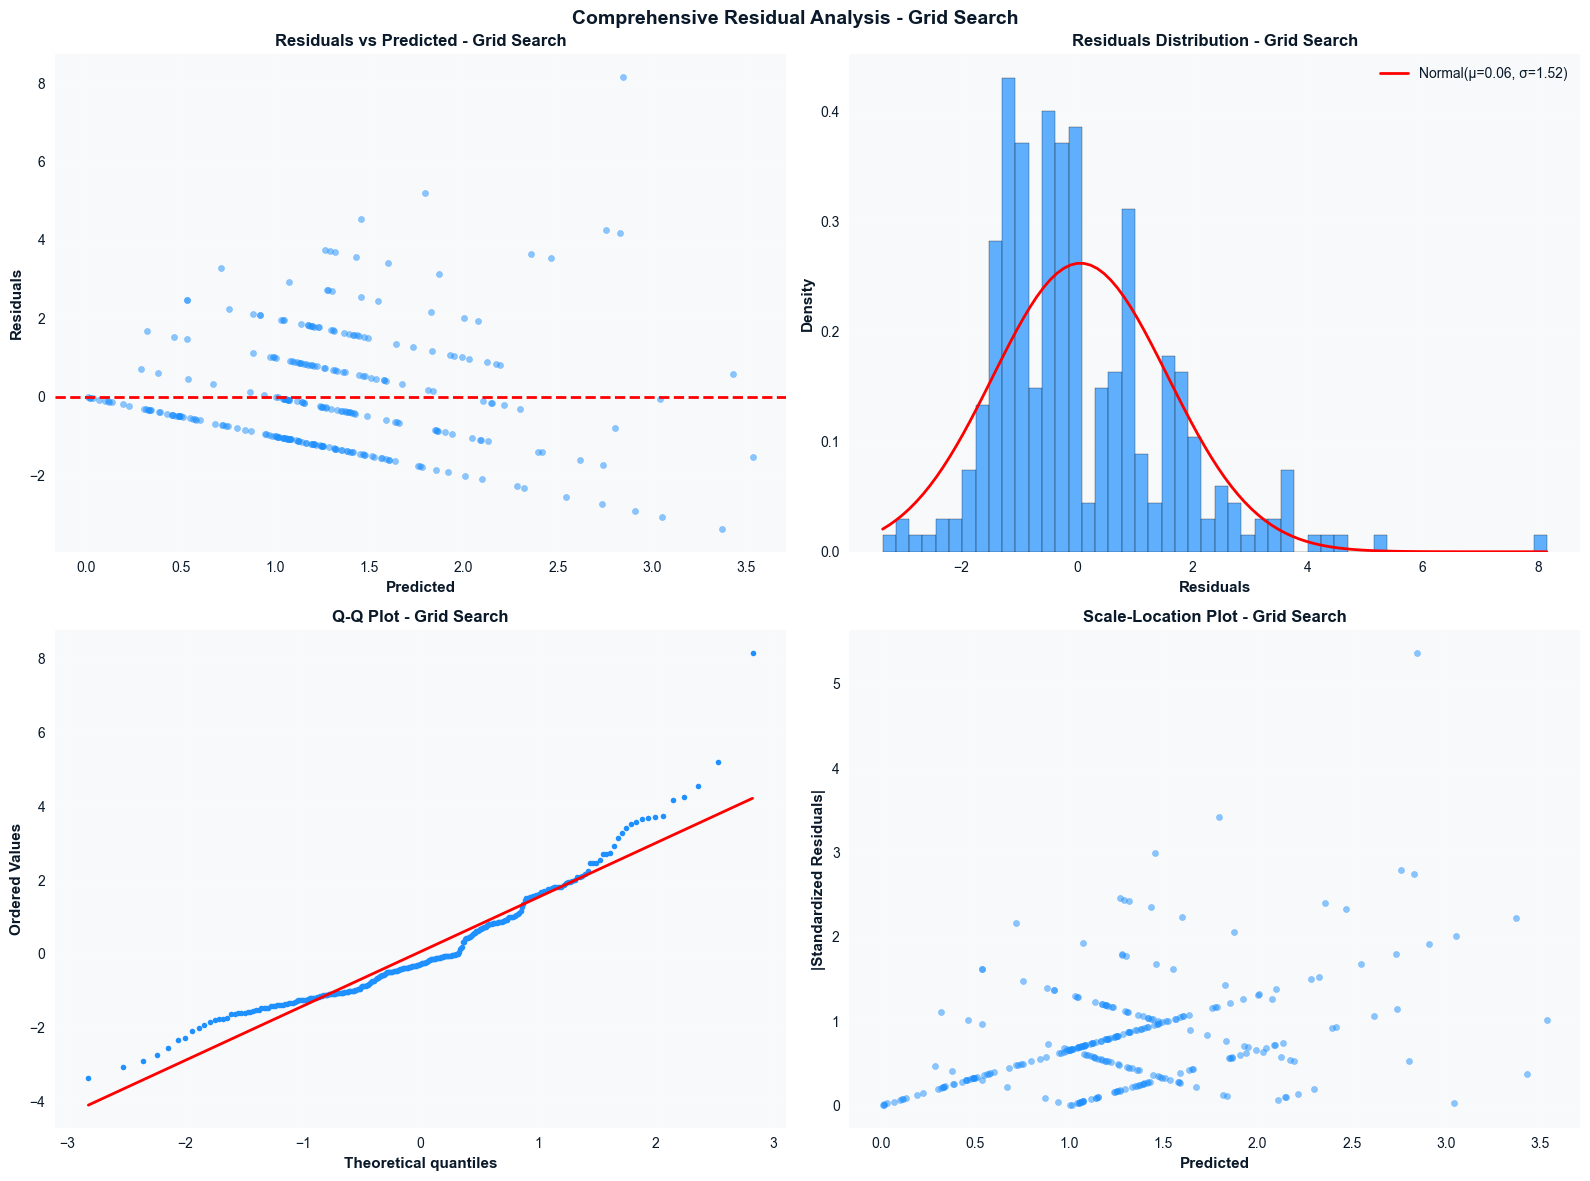

In [15]:
# =============================================================================
# ANALYZE SINGLE MODEL PERFORMANCE
# =============================================================================

print("📊 ANALYZING MODEL PERFORMANCE")
print("=" * 50)

# Analyze baseline model
print("\n🔍 BASELINE MODEL ANALYSIS:")
random_forest_pipeline.plot_single_model_analysis("random_forest")

# Analyze grid search model
print("\n🔍 GRID SEARCH MODEL ANALYSIS:")
random_forest_pipeline.plot_single_model_analysis("random_forest_grid")


🔍 RANDOM SEARCH MODEL ANALYSIS:

📊 Generating analysis plots for Random Search...
   📈 Actual vs Predicted...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/05_actual_vs_predicted_random_forest_random.png


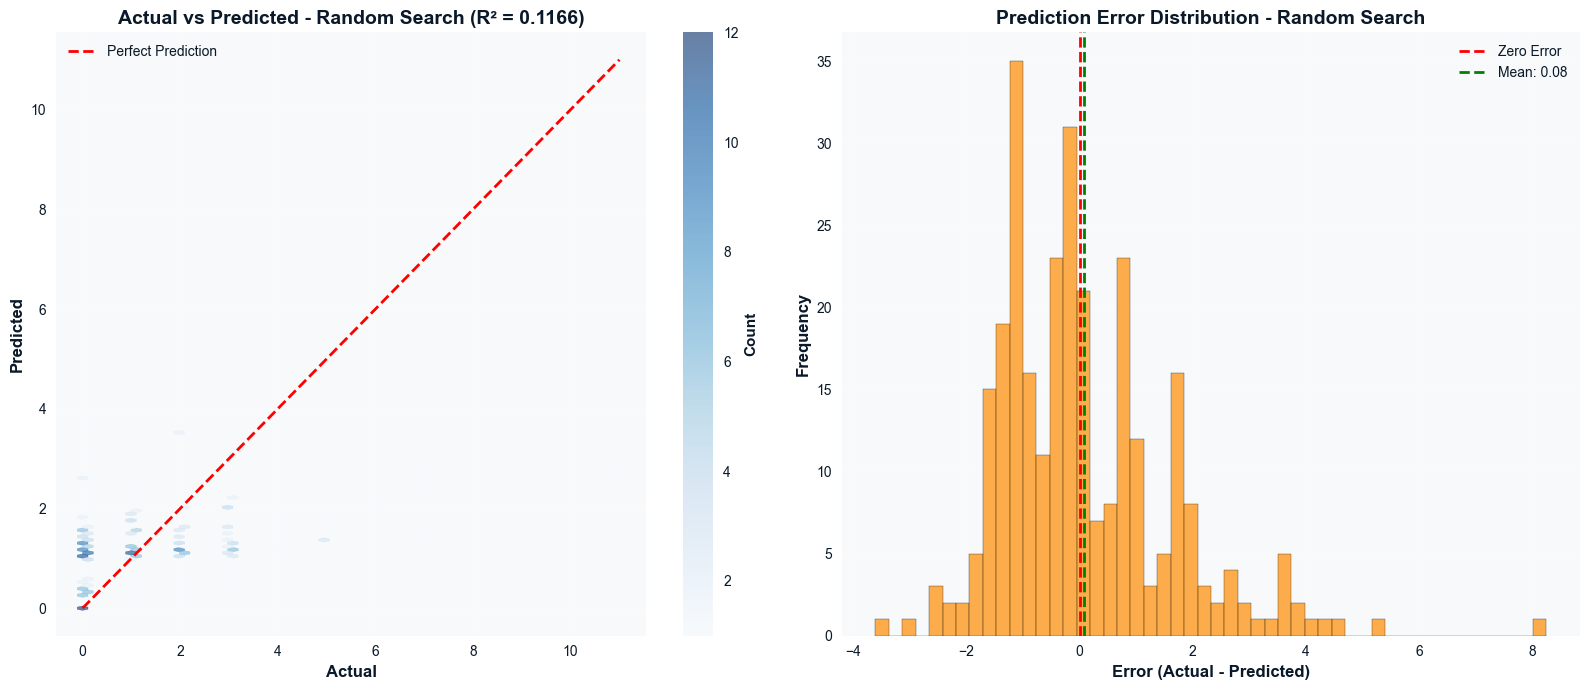

   📊 Residuals analysis...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/06_residuals_analysis_random_forest_random.png


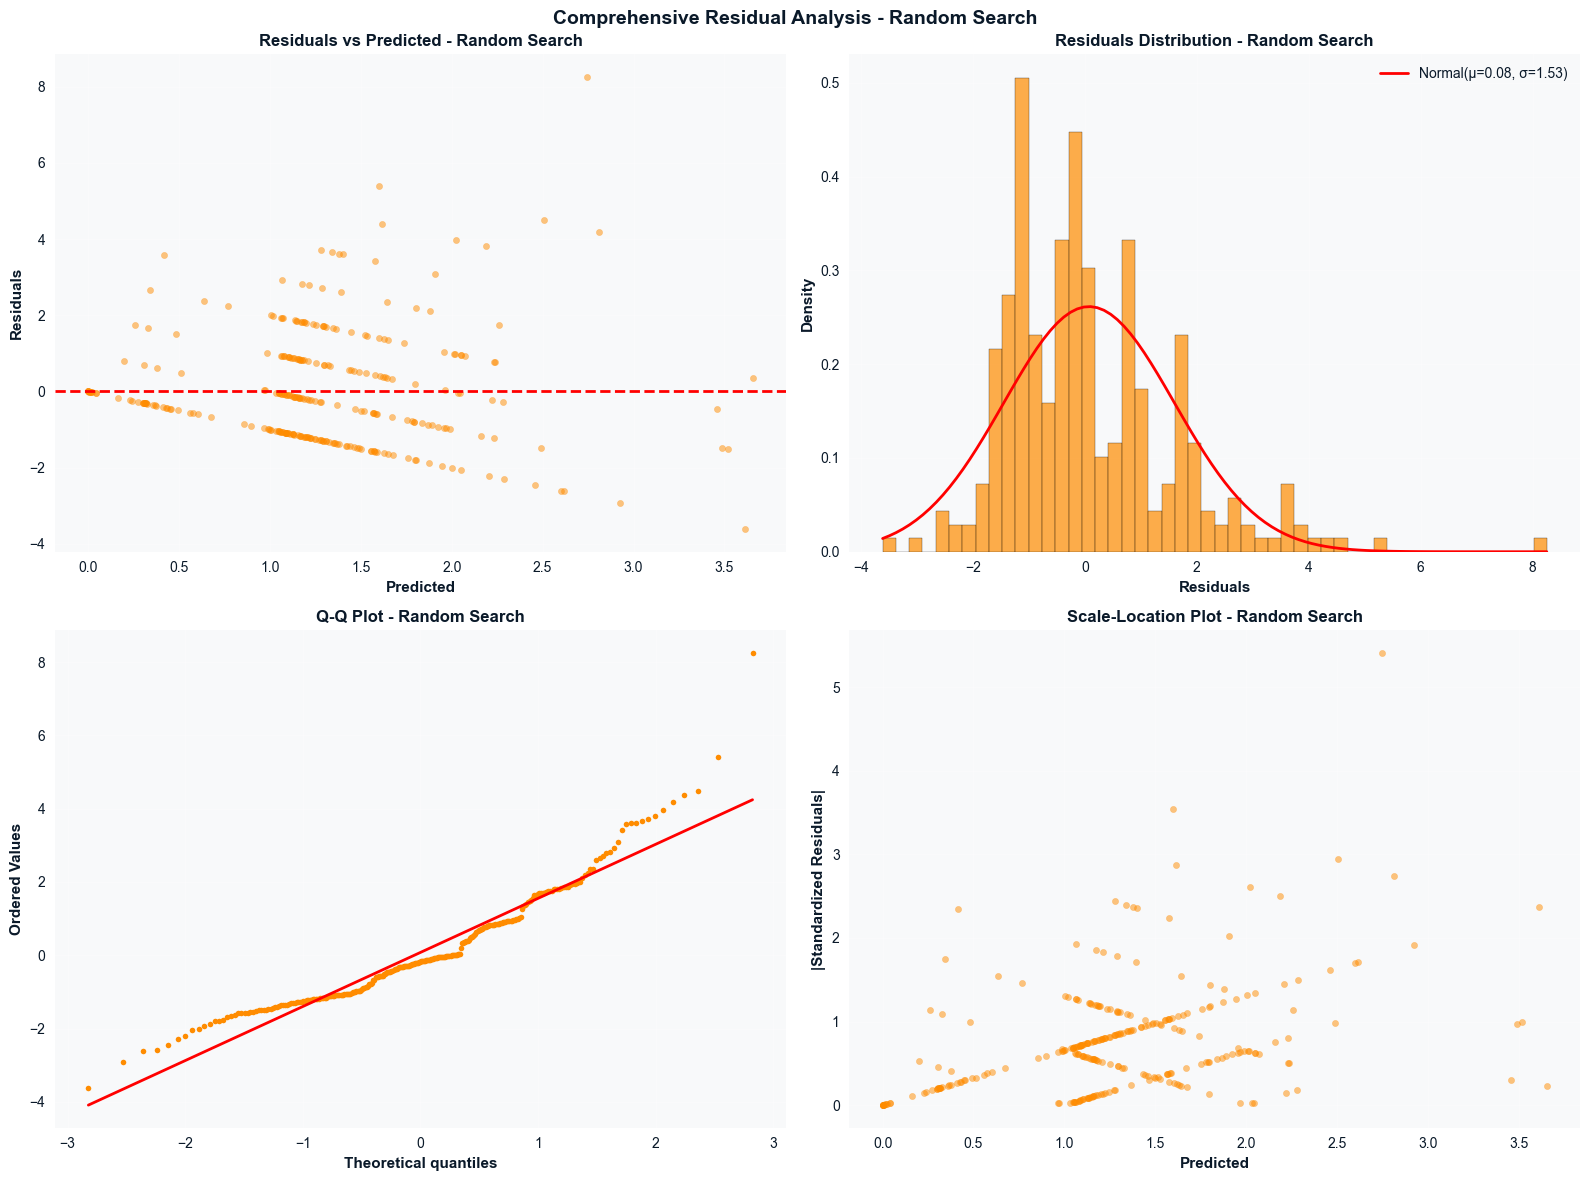


🔍 HYPEROPT MODEL ANALYSIS:

📊 Generating analysis plots for Hyperopt...
   📈 Actual vs Predicted...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/05_actual_vs_predicted_random_forest_hyperopt.png


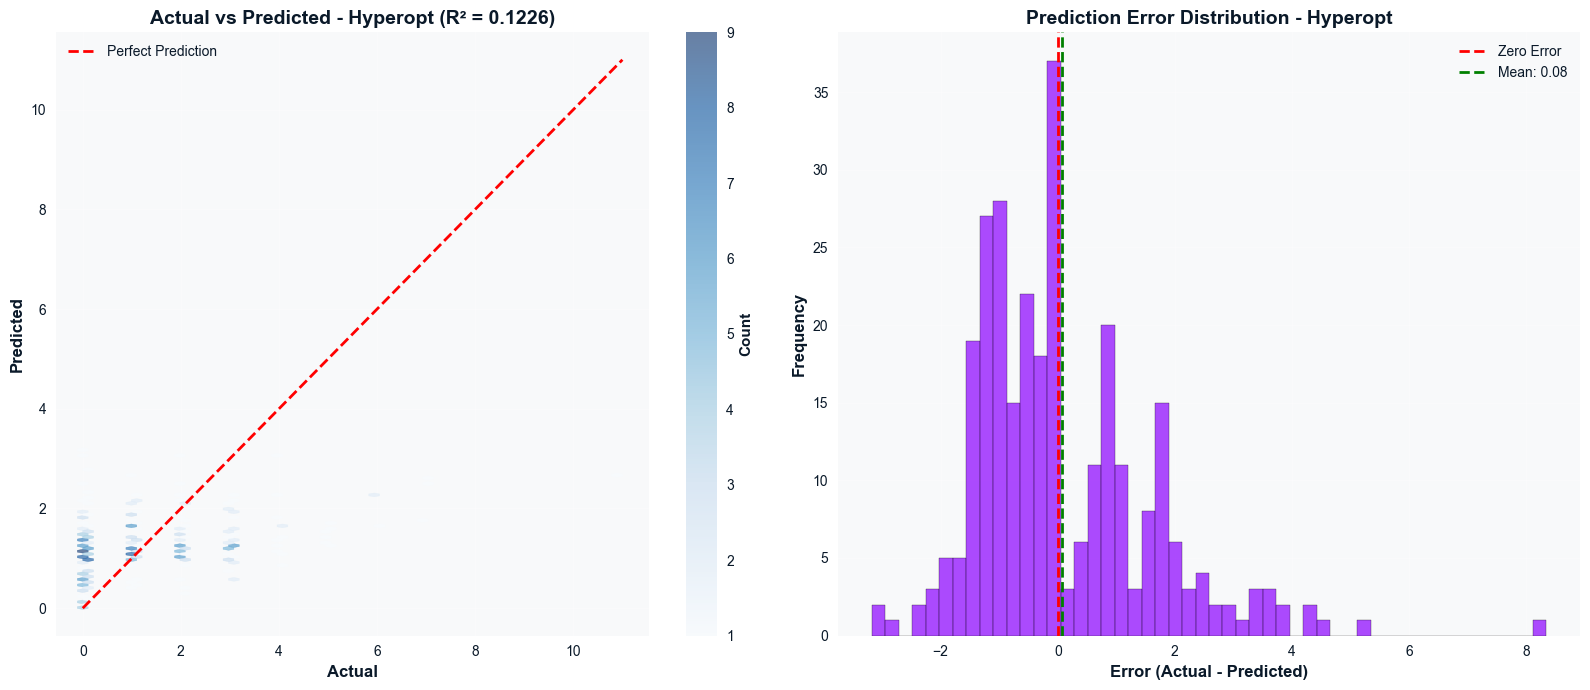

   📊 Residuals analysis...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/06_residuals_analysis_random_forest_hyperopt.png


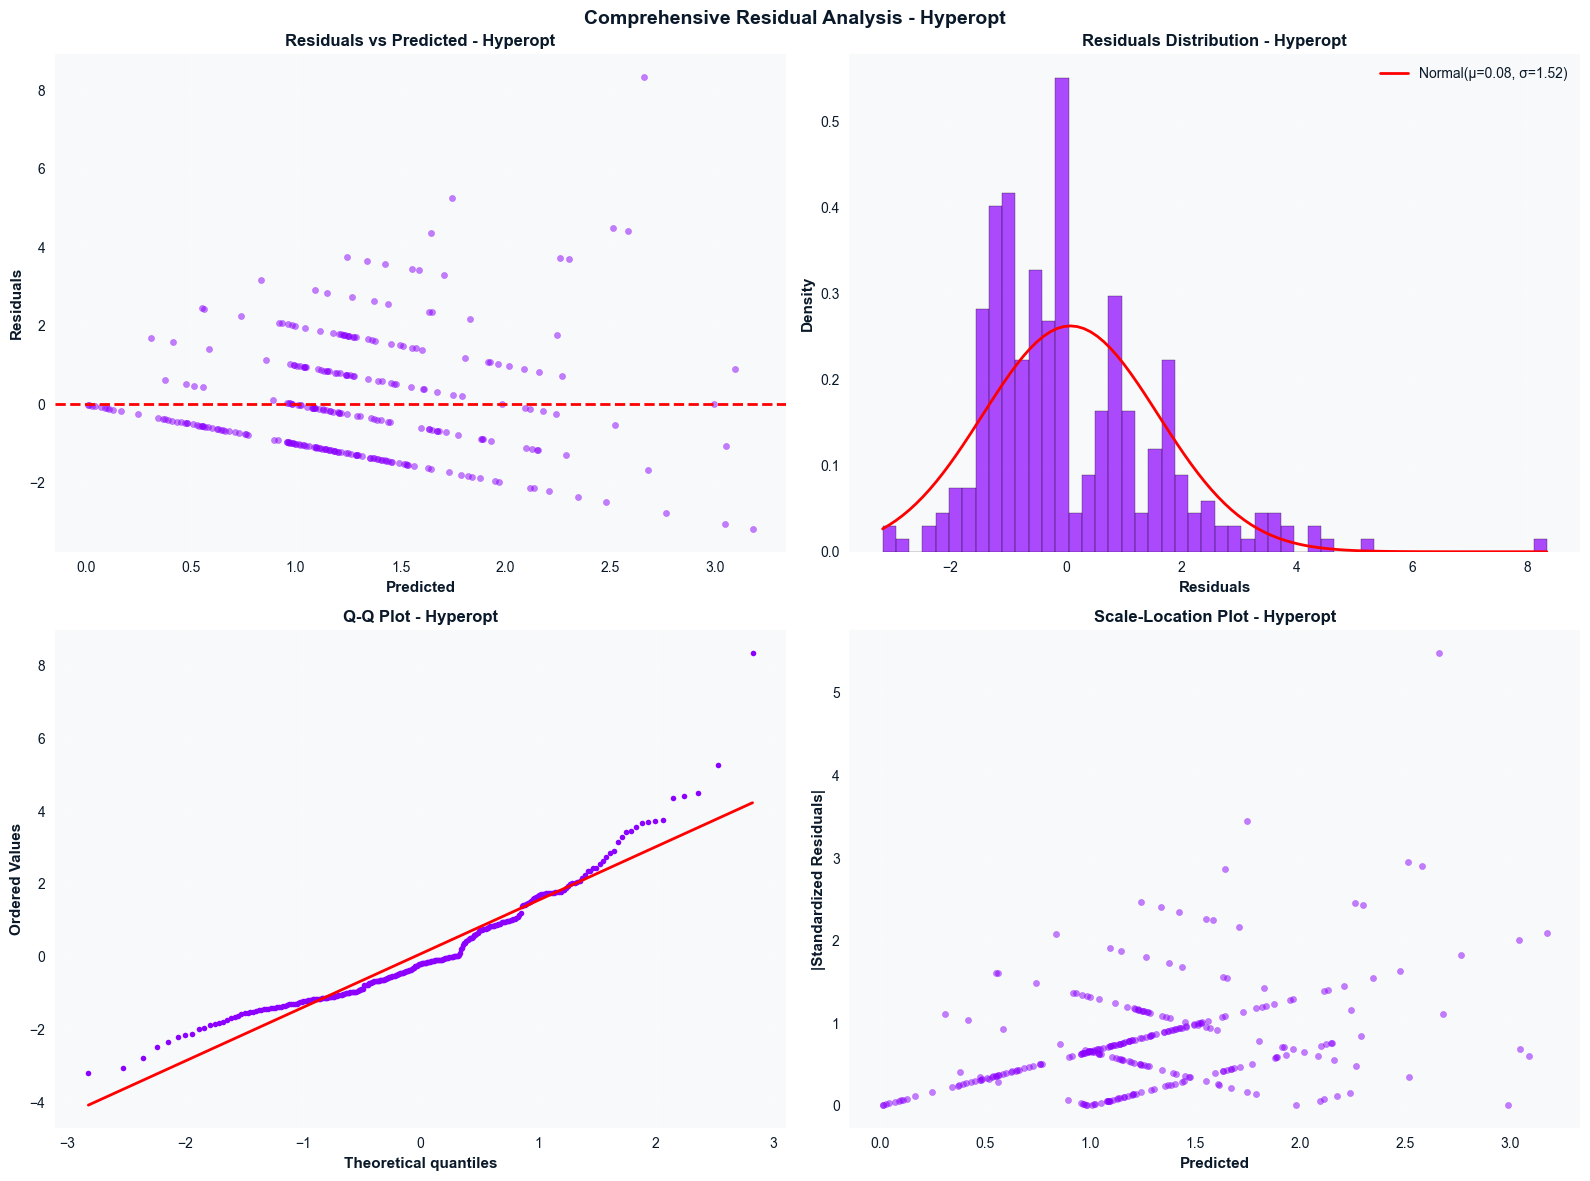

In [16]:
# Analyze baseline model
print("\n🔍 RANDOM SEARCH MODEL ANALYSIS:")
random_forest_pipeline.plot_single_model_analysis("random_forest_random")

# Analyze grid search model
print("\n🔍 HYPEROPT MODEL ANALYSIS:")
random_forest_pipeline.plot_single_model_analysis("random_forest_hyperopt")

## 7️⃣ FEATURE IMPORTANCE ANALYSIS

🎯 FEATURE IMPORTANCE ANALYSIS

📊 BASELINE MODEL FEATURE IMPORTANCE:
⚠️  Error extracting feature names: This SimpleImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

📊 Top 10 Feature Importance for random_forest:
            feature  importance  importance_pct
 unit_sales_r7_mean    0.396168       39.616773
  unit_sales_r7_std    0.144830       14.482985
 days_since_holiday    0.071867        7.186720
 days_until_holiday    0.070484        7.048444
unit_sales_r30_mean    0.067413        6.741337
unit_sales_r14_mean    0.056578        5.657840
        day_of_week    0.054505        5.450456
  unit_sales_lag_14    0.034659        3.465893
  unit_sales_lag_30    0.030933        3.093315
   unit_sales_lag_7    0.029425        2.942471
💾 Feature importance saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest/random_forest_feature_importance.csv
       

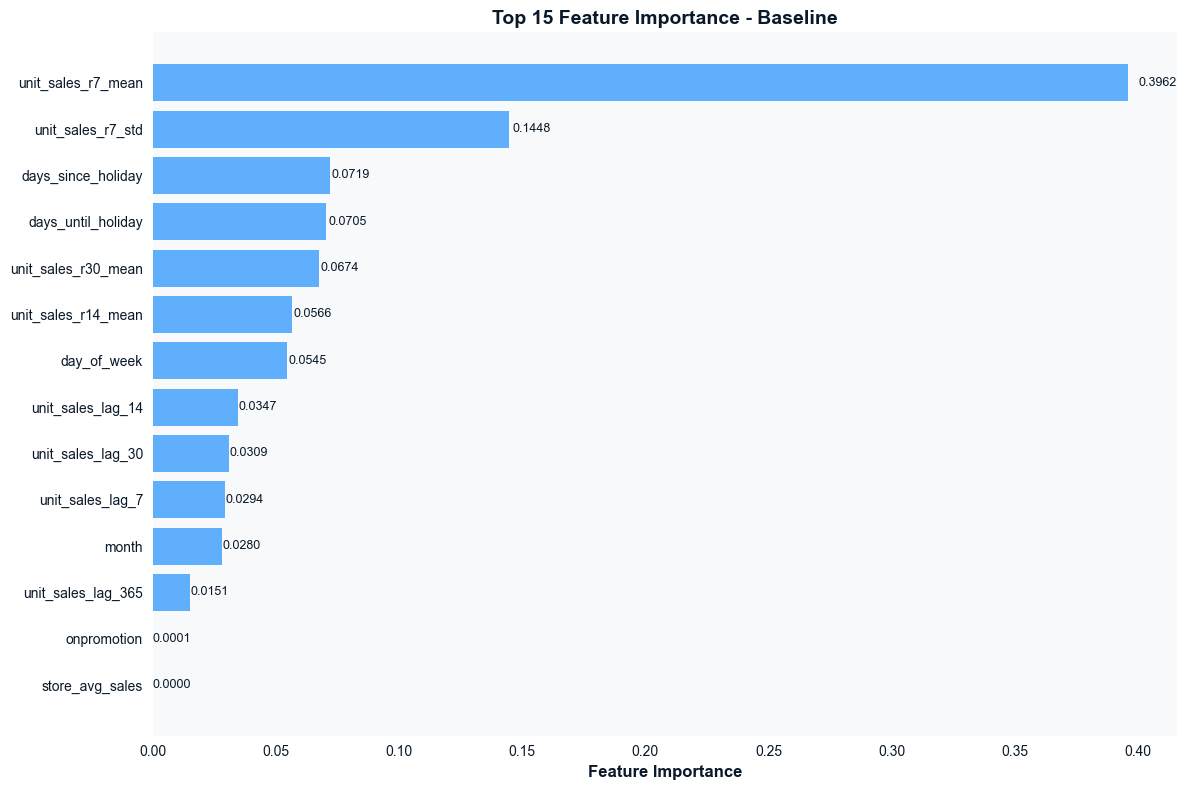

✅ Feature importance plot saved: feature_importance_random_forest.png

📊 COMPARING FEATURE IMPORTANCE ACROSS MODELS:
⚠️  Error extracting feature names: This SimpleImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

📊 Top 5 Feature Importance for random_forest:
            feature  importance  importance_pct
 unit_sales_r7_mean    0.396168       39.616773
  unit_sales_r7_std    0.144830       14.482985
 days_since_holiday    0.071867        7.186720
 days_until_holiday    0.070484        7.048444
unit_sales_r30_mean    0.067413        6.741337
💾 Feature importance saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest/random_forest_feature_importance.csv

random_forest:
                feature  importance
5    unit_sales_r7_mean    0.396168
8     unit_sales_r7_std    0.144830
12   days_since_holiday    0.071867
11   days_until_holiday    0.070484
7  

In [17]:
# =============================================================================
# CELL 10: FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature importance for baseline model
print("\n📊 BASELINE MODEL FEATURE IMPORTANCE:")
importance_df = random_forest_pipeline.get_feature_importance("random_forest", top_n=10)
print(importance_df)

# Plot feature importance
random_forest_pipeline.plot_feature_importance_analysis("random_forest", top_n=15)
# Compare feature importance across models
print("\n📊 COMPARING FEATURE IMPORTANCE ACROSS MODELS:")
for variant in random_forest_pipeline.MODEL_VARIANTS:
    if variant in random_forest_pipeline._trained_variants:
        importance = random_forest_pipeline.get_feature_importance(variant, top_n=5)
        print(f"\n{variant}:")
        print(importance[['feature', 'importance']].head())

## 8️⃣  MODEL COMPARISON VISUALIZATIONS

📈 GENERATING MODEL COMPARISON VISUALIZATIONS

GENERATING RANDOM FOREST MODEL COMPARISON PLOTS
📊 Generating multi-model comparison...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/07_multi_model_comparison.png


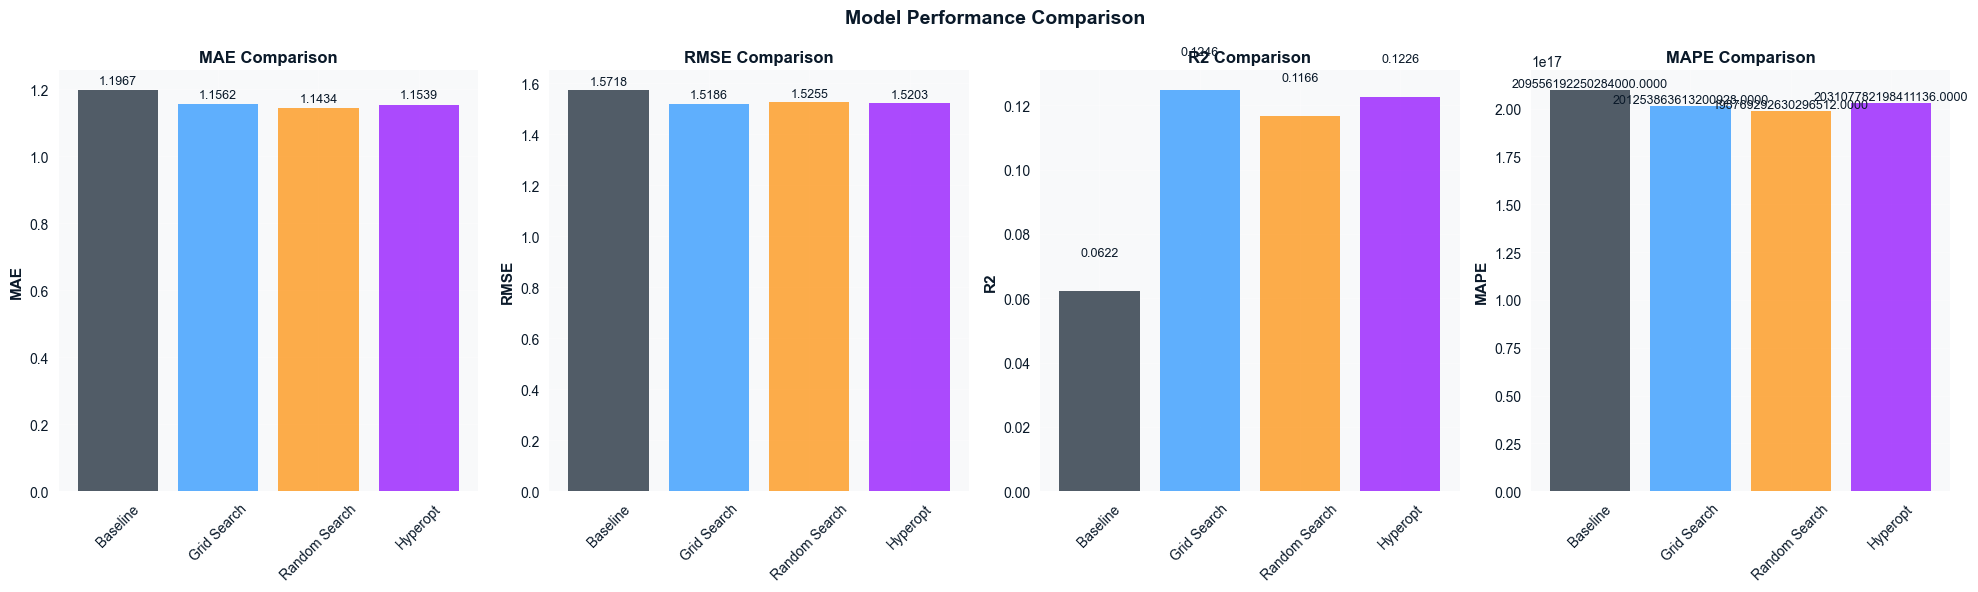

📊 Generating multi-model actual vs predicted...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/08_multi_model_actual_vs_predicted.png


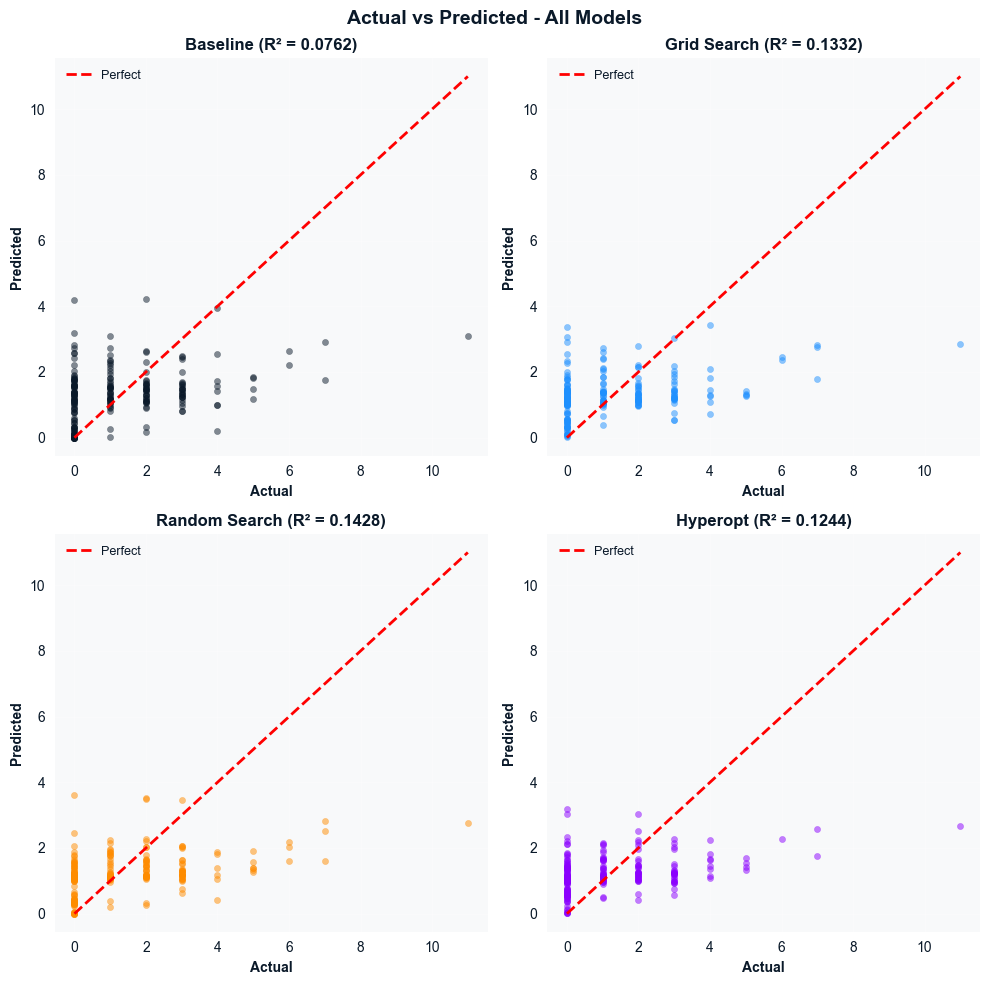

📊 Generating multi-model time series comparison...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/09_multi_model_time_series_comparison.png


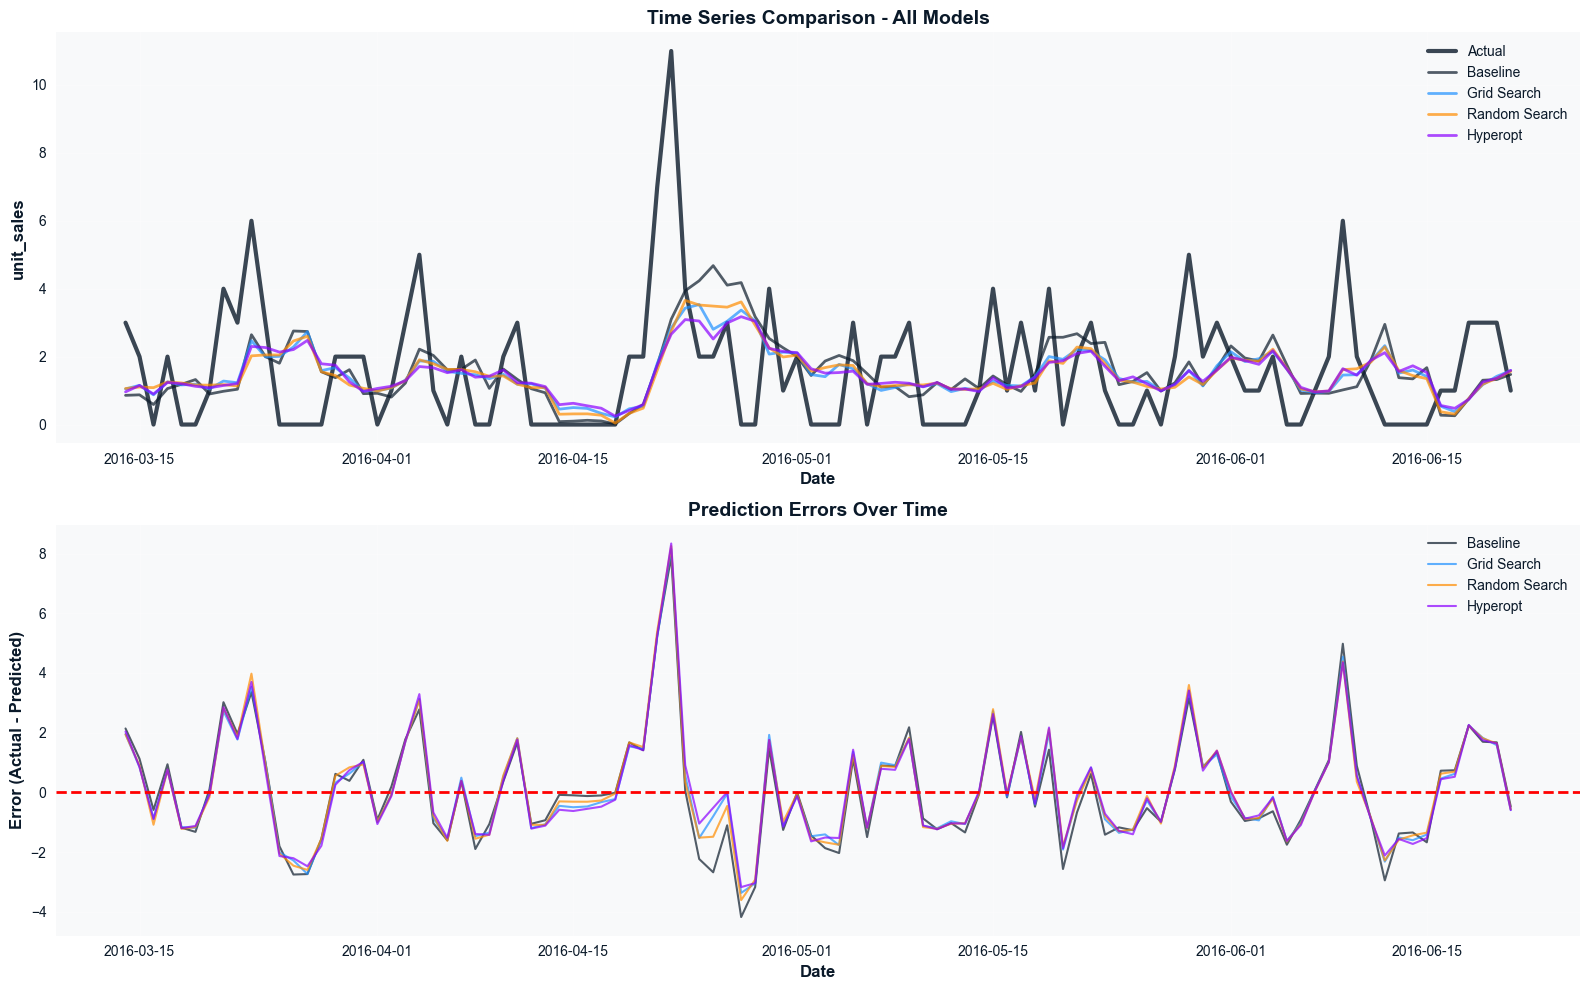

📊 Generating error distribution comparison...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/11_error_distribution_comparison.png


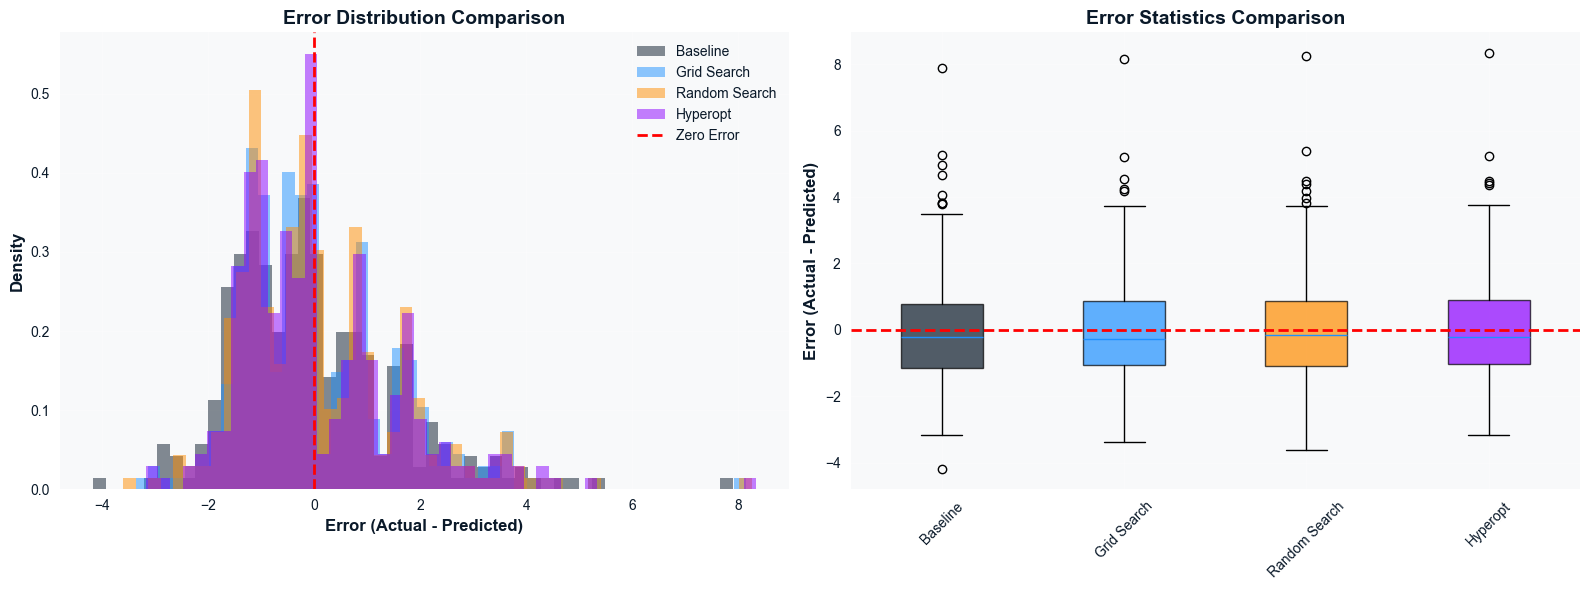

📊 Generating daily overlay subplots...

[DEBUG][plot_all_predictions_overlay_daily] Starting daily overlay subplot plot...
[DEBUG] y_true, dates, and model_predictions validated.
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/14_all_predictions_overlay_daily_subplots.png


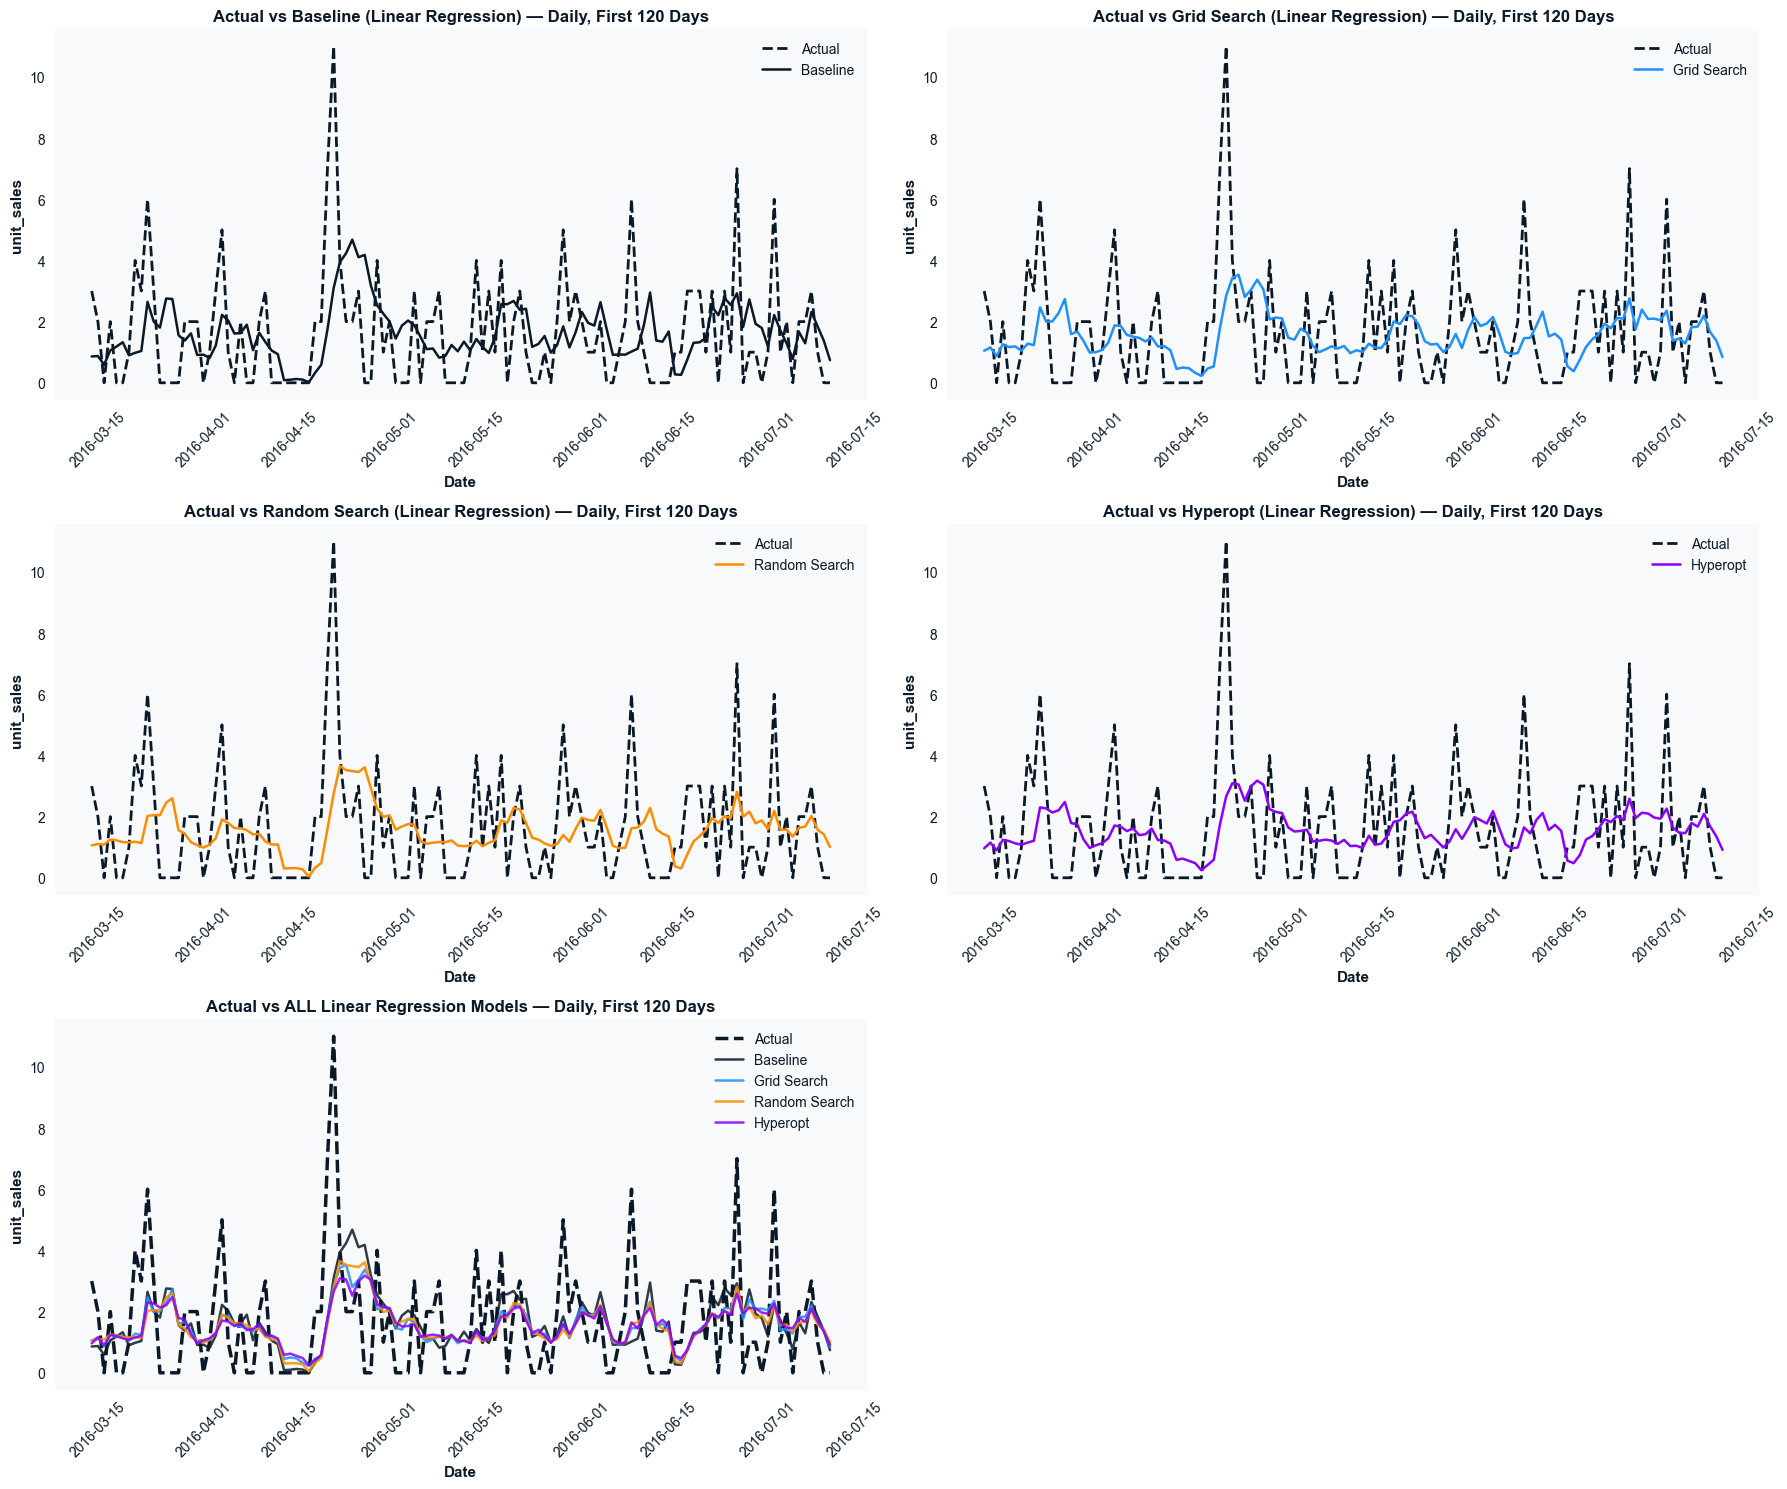

[DEBUG][plot_all_predictions_overlay_daily] Completed.

📊 Generating monthly overlay...

[DEBUG][plot_all_predictions_overlay_monthly] Starting monthly overlay plot...
[DEBUG] y_true, dates, and model_predictions validated.
[DEBUG] y_true length: 292
[DEBUG] Base DataFrame shape: (292, 2)
[DEBUG] Processing model: random_forest → display name: Baseline
[DEBUG] Converting predictions of random_forest to pandas Series.
[DEBUG] Aligning lengths → min_len = 292
[DEBUG] Added column 'Baseline' to DataFrame.
[DEBUG] Processing model: random_forest_grid → display name: Grid Search
[DEBUG] Converting predictions of random_forest_grid to pandas Series.
[DEBUG] Aligning lengths → min_len = 292
[DEBUG] Added column 'Grid Search' to DataFrame.
[DEBUG] Processing model: random_forest_random → display name: Random Search
[DEBUG] Converting predictions of random_forest_random to pandas Series.
[DEBUG] Aligning lengths → min_len = 292
[DEBUG] Added column 'Random Search' to DataFrame.
[DEBUG] Processi

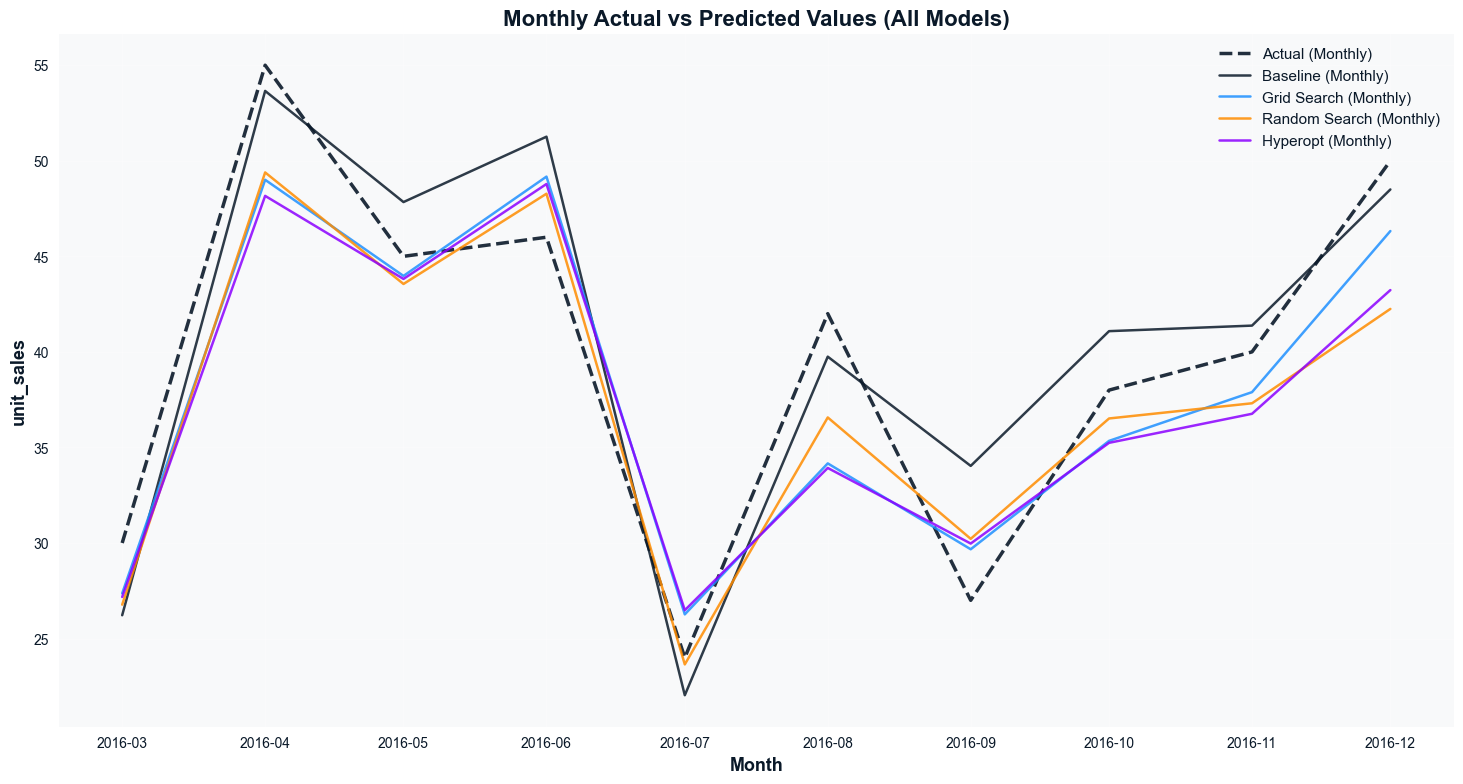

[DEBUG][plot_all_predictions_overlay_monthly] Completed.

📊 Generating model performance radar...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/10_model_performance_radar.png


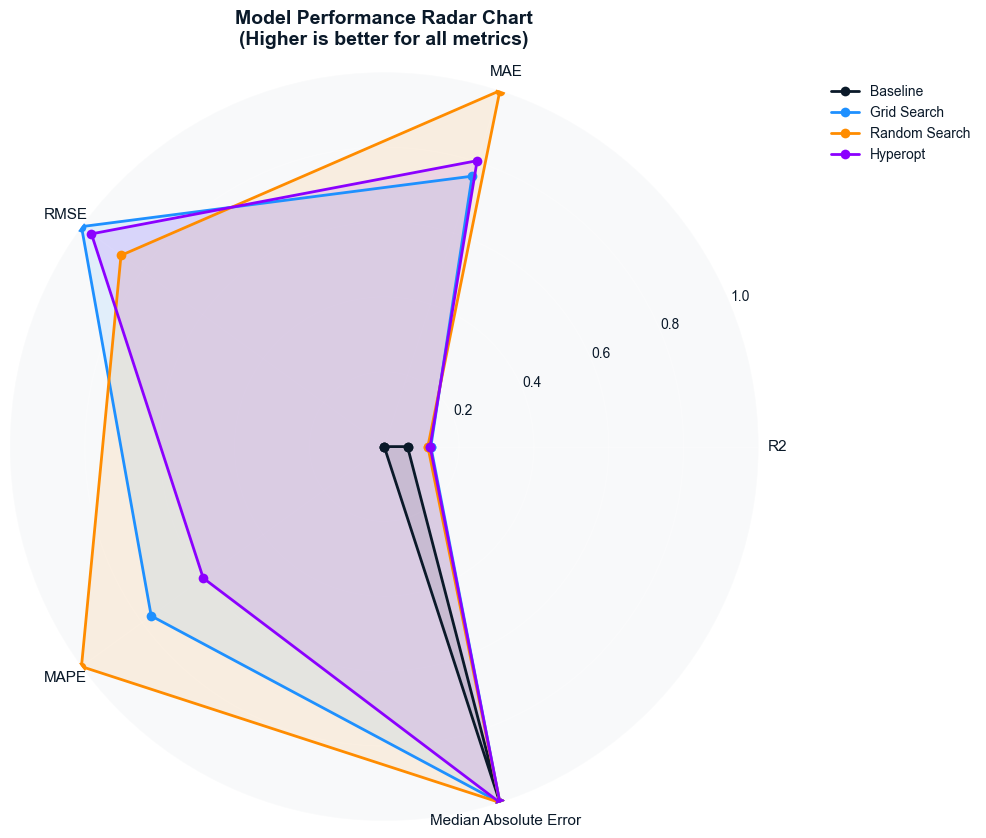


✅ Random Forest comparison plots generation complete!



In [19]:
# =============================================================================
# CELL 11: MODEL COMPARISON VISUALIZATIONS
# =============================================================================

print("📈 GENERATING MODEL COMPARISON VISUALIZATIONS")
print("=" * 50)

# Generate all comparison plots
random_forest_pipeline.plot_model_comparison()

# Or generate specific comparisons:
# random_forest_pipeline.visualizer.plot_multi_model_comparison()
# random_forest_pipeline.visualizer.plot_multi_model_actual_vs_predicted()
# random_forest_pipeline.visualizer.plot_multi_model_time_series_comparison()

## 9️⃣ FUTURE FORECASTING

In [24]:
# =============================================================================
# FUTURE FORECASTING
# =============================================================================

print("🔮 FUTURE FORECASTING WITH RANDOM FOREST")
print("=" * 50)

# Generate 30-day forecast using the best model
forecast_results = random_forest_pipeline.forecast_future(
    forecast_horizon=30,        # Forecast 30 periods
    frequency="D",              # Daily frequency
    variant_name=None,          # Use best model automatically
    confidence_level=0.95,      # 95% confidence interval
    n_bootstrap=50              # Bootstrap samples for uncertainty
)

print("\n📊 FORECAST RESULTS SUMMARY:")
print(f"Model used: {forecast_results['model_variant']}")
print(f"Forecast horizon: {forecast_results['forecast_horizon']} days")
print(f"Mean forecast: {forecast_results['statistics']['mean_forecast']:.2f}")

🔮 FUTURE FORECASTING WITH RANDOM FOREST

🔮 RANDOM FOREST FUTURE FORECASTING

📊 MODEL RANKING BY RMSE
                          rmse     mae      r2  rank
random_forest_grid      1.5186  1.1562  0.1246     1
random_forest_hyperopt  1.5203  1.1539  0.1226     2
random_forest_random    1.5255  1.1434  0.1166     3
random_forest           1.5718  1.1967  0.0622     4

--------------------------------------------------------------------------------
🏆 BEST MODEL: random_forest_grid
   → RMSE: 1.5186
   → Full metrics: {'rmse': 1.5186, 'mae': 1.1562, 'r2': 0.1246}

📊 Using best model: random_forest_grid
📅 Preparing future features for 30 periods...
✅ Future features prepared: (30, 14)
📈 Generating point forecasts...
🎲 Estimating uncertainty with bootstrap...
   Running 50 bootstrap iterations...
💾 Forecast saved to CSV: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest/random_forest_grid_forecast_30periods.csv

### 9.1 VISUALIZE FORECASTS

📈 VISUALIZING FORECASTS
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/random_forest_grid_forecast_plot.png
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest/random_forest_grid_forecast_distribution.png

📊 GENERATING COMPREHENSIVE FORECAST REPORT

🔮 RANDOM FOREST FUTURE FORECASTING
📅 Preparing future features for 30 periods...
✅ Future features prepared: (30, 14)
📈 Generating point forecasts...
🎲 Estimating uncertainty with bootstrap...
   Running 100 bootstrap iterations...
💾 Forecast saved to CSV: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest/random_forest_grid_forecast_30periods.csv
💾 Forecast metadata saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retai

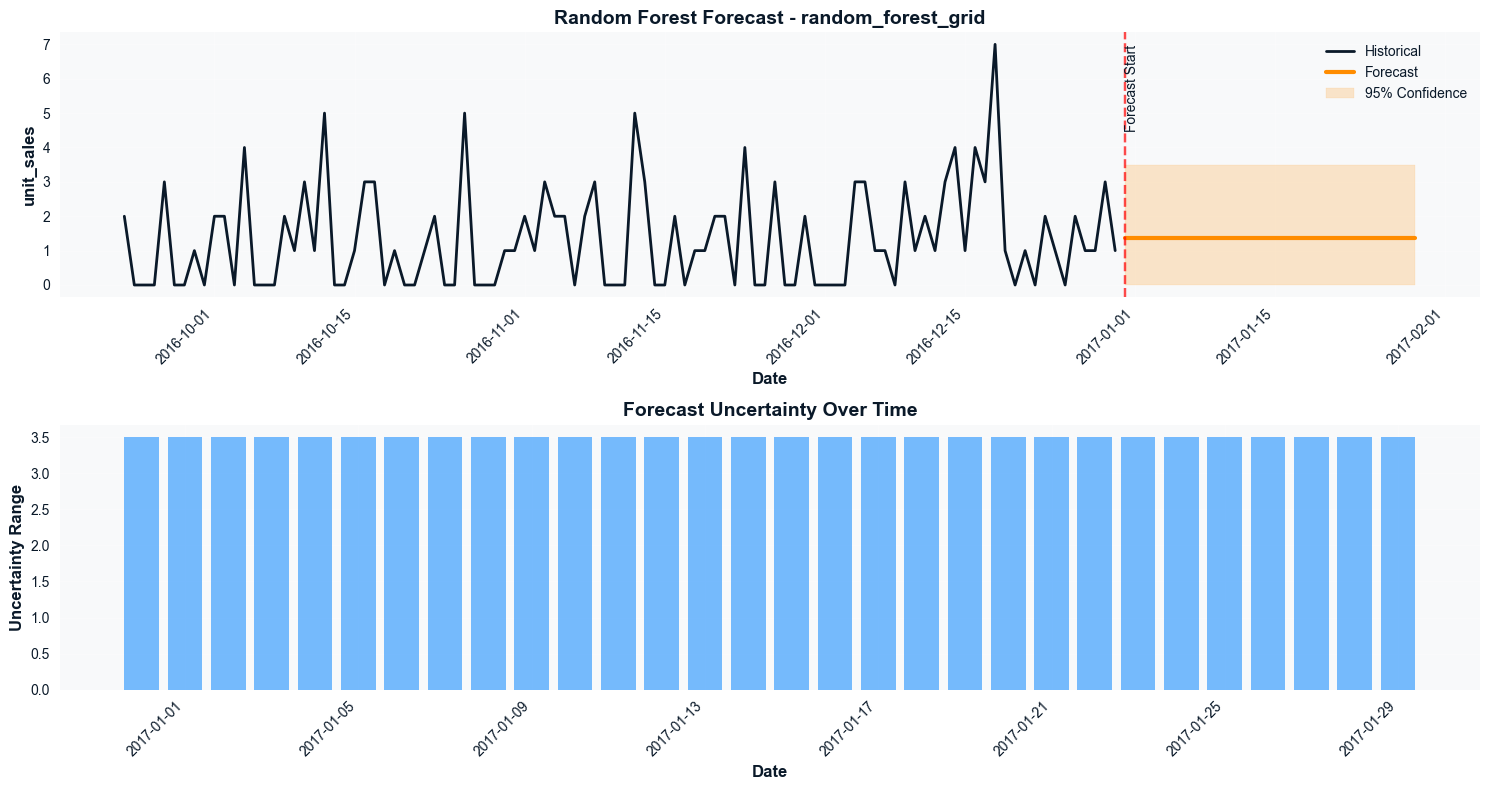

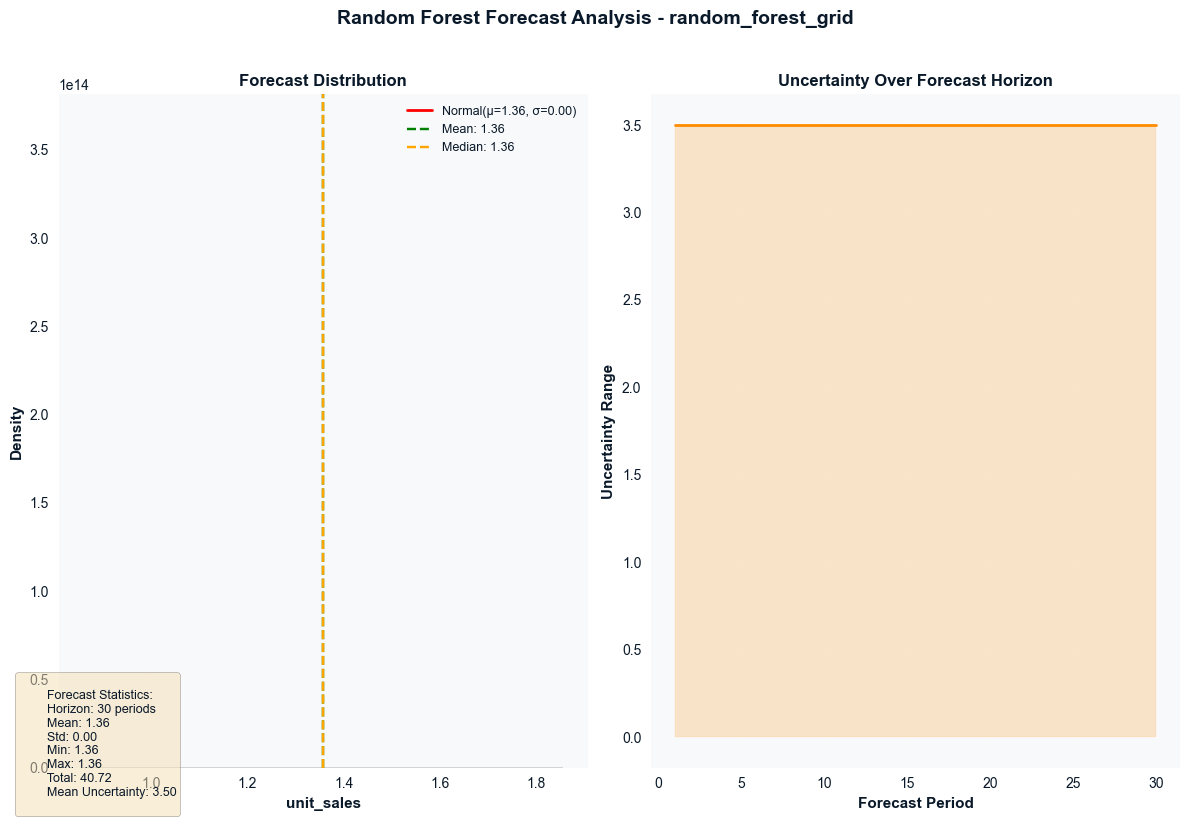

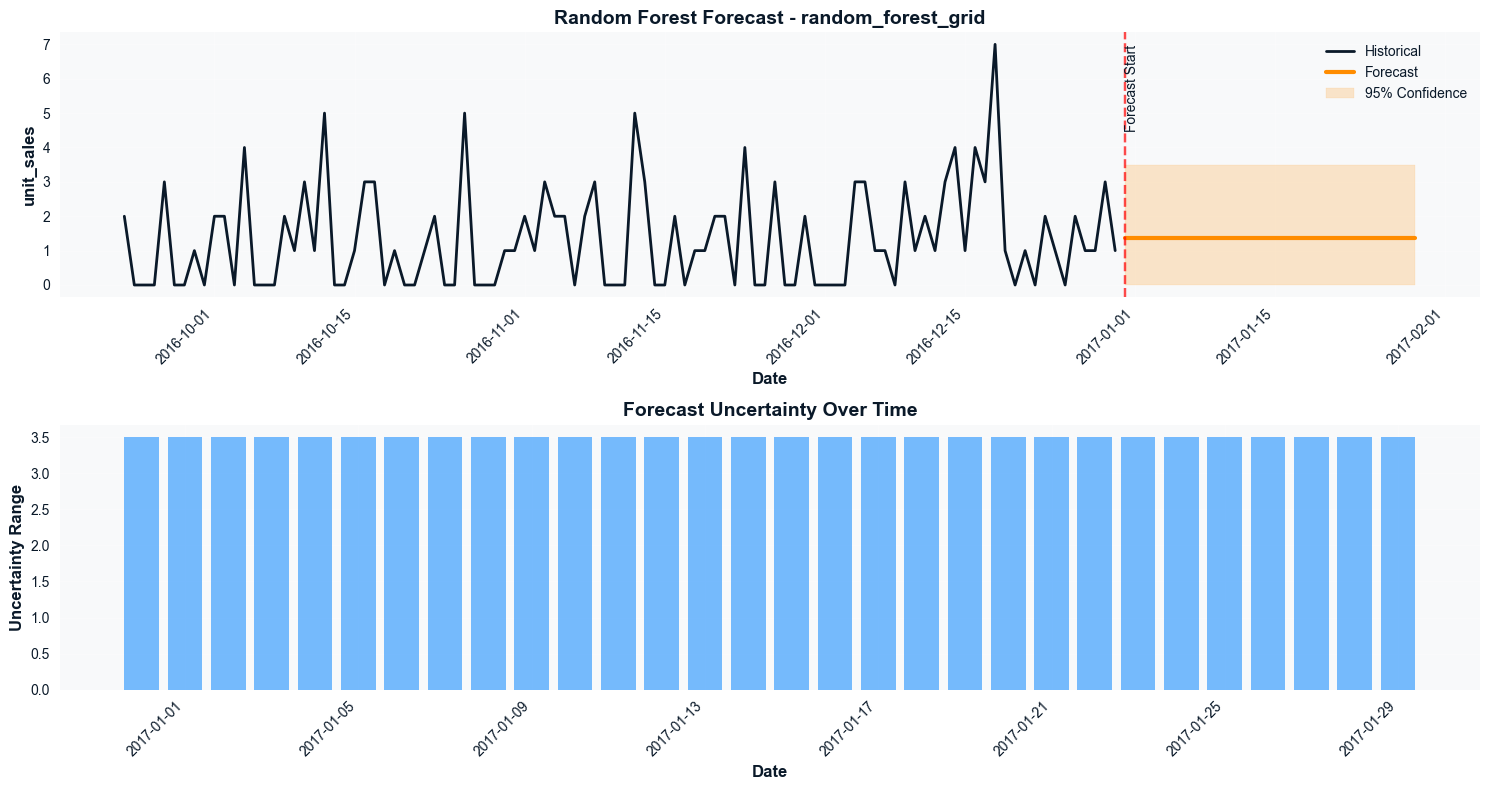

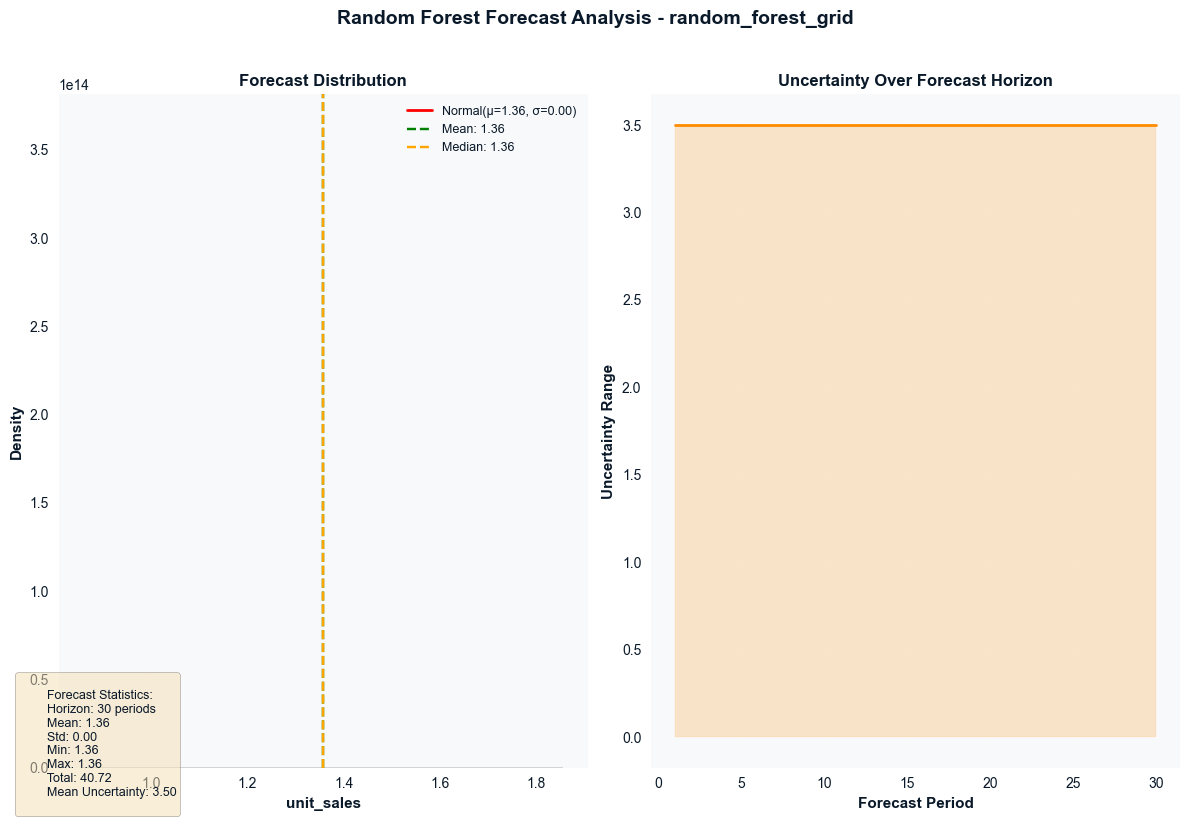

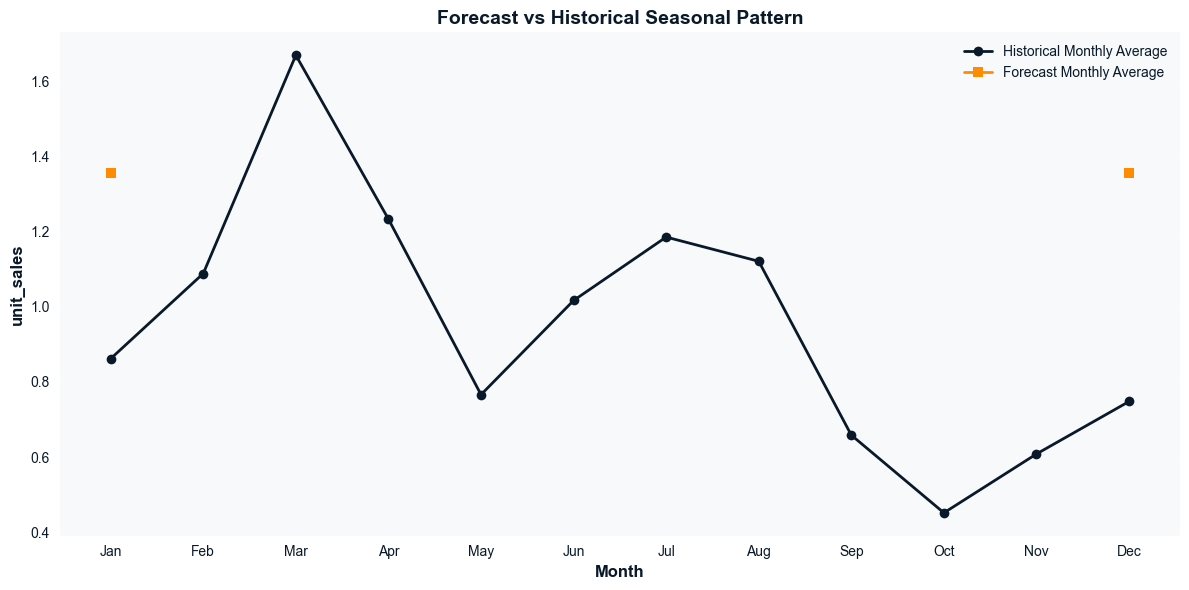

   📋 Creating forecast summary...

FORECAST SUMMARY TABLE
Model Variant                 : random_forest_grid
Forecast Horizon              : 30 periods
Frequency                     : D
Confidence Level              : 95.0%
Mean Forecast                 : 1.36
Median Forecast               : 1.36
Std Forecast                  : 0.00
Min Forecast                  : 1.36
Max Forecast                  : 1.36
Total Forecast                : 40.72
Mean Uncertainty              : 3.50
Uncertainty Ratio             : 2.579

First 10 Forecast Values:
----------------------------------------
Date            Point Forecast  Lower Bound     Upper Bound    
----------------------------------------
2016-12-31                 1.36            0.00            3.50
2017-01-01                 1.36            0.00            3.50
2017-01-02                 1.36            0.00            3.50
2017-01-03                 1.36            0.00            3.50
2017-01-04                 1.36            0.00  

In [25]:
# =============================================================================
# VISUALIZE FORECASTS
# =============================================================================

print("📈 VISUALIZING FORECASTS")
print("=" * 50)

# Plot the forecast
random_forest_pipeline.plot_forecast(forecast_results, historical_points=100)

# Plot forecast distribution
random_forest_pipeline.plot_forecast_distribution(forecast_results)

# Generate comprehensive forecast report
complete_forecast = random_forest_pipeline.generate_forecast_report(
    forecast_horizon=30,
    frequency="D",
    variant_name="random_forest_grid"  # Or None for best model
)

### 9.2  ANALYZE FORECAST RESULTS

In [26]:
# =============================================================================
# ANALYZE FORECAST RESULTS
# =============================================================================

print("📊 ANALYZING FORECAST RESULTS")
print("=" * 50)

# Convert forecast results to DataFrame for analysis
forecast_df = pd.DataFrame({
    'date': forecast_results['forecast_dates'],
    'point_forecast': forecast_results['point_forecasts'],
    'lower_bound': forecast_results['lower_bounds'],
    'upper_bound': forecast_results['upper_bounds'],
    'uncertainty': forecast_results['upper_bounds'] - forecast_results['lower_bounds']
})

print("📅 FORECAST DATA (first 10 rows):")
print(forecast_df.head(10))

print("\n📊 FORECAST STATISTICS:")
print(f"Total forecast sum: {forecast_df['point_forecast'].sum():.2f}")
print(f"Average uncertainty: {forecast_df['uncertainty'].mean():.2f}")
print(f"Min forecast: {forecast_df['point_forecast'].min():.2f}")
print(f"Max forecast: {forecast_df['point_forecast'].max():.2f}")

📊 ANALYZING FORECAST RESULTS
📅 FORECAST DATA (first 10 rows):
        date  point_forecast  lower_bound  upper_bound  uncertainty
0 2016-12-31        1.357177          0.0          3.5          3.5
1 2017-01-01        1.357177          0.0          3.5          3.5
2 2017-01-02        1.357177          0.0          3.5          3.5
3 2017-01-03        1.357177          0.0          3.5          3.5
4 2017-01-04        1.357177          0.0          3.5          3.5
5 2017-01-05        1.357177          0.0          3.5          3.5
6 2017-01-06        1.357177          0.0          3.5          3.5
7 2017-01-07        1.357177          0.0          3.5          3.5
8 2017-01-08        1.357177          0.0          3.5          3.5
9 2017-01-09        1.357177          0.0          3.5          3.5

📊 FORECAST STATISTICS:
Total forecast sum: 40.72
Average uncertainty: 3.50
Min forecast: 1.36
Max forecast: 1.36


### 9.3 ADVANCED ANALYSIS & EXPERIMENTATION

In [30]:
# =============================================================================
# ADVANCED ANALYSIS & EXPERIMENTATION
# =============================================================================

print("🔬 ADVANCED ANALYSIS & EXPERIMENTATION")
print("=" * 50)

# 1. Compare different forecast horizons
forecast_horizons = [7, 14, 30, 60]
forecast_results_by_horizon = {}

for horizon in forecast_horizons:
    print(f"\n📊 Forecasting {horizon} days...")
    results = random_forest_pipeline.forecast_future(
        forecast_horizon=horizon,
        frequency="D",
        variant_name="random_forest"
    )
    forecast_results_by_horizon[horizon] = results
    print(f"   Mean forecast: {results['statistics']['mean_forecast']:.2f}")

# 2. Try different confidence levels
confidence_levels = [0.90, 0.95, 0.99]
for confidence in confidence_levels:
    print(f"\n📊 {confidence*100:.0f}% Confidence Interval:")
    results = random_forest_pipeline.forecast_future(
        forecast_horizon=30,
        frequency="D",
        confidence_level=confidence
    )
    uncertainty = results['upper_bounds'] - results['lower_bounds']
    print(f"   Average uncertainty: {uncertainty.mean():.2f}")

# 3. Compare different model variants
print("\n📊 COMPARING MODEL VARIANTS FOR FORECASTING:")
for variant in random_forest_pipeline.MODEL_VARIANTS:
    if variant in random_forest_pipeline._trained_variants:
        print(f"\n{variant}:")
        results = random_forest_pipeline.forecast_future(
            forecast_horizon=30,
            frequency="D",
            variant_name=variant
        )
        print(f"   Mean forecast: {results['statistics']['mean_forecast']:.2f}")
        print(f"   Uncertainty: {results['statistics']['mean_uncertainty']:.2f}")

🔬 ADVANCED ANALYSIS & EXPERIMENTATION

📊 Forecasting 7 days...

🔮 RANDOM FOREST FUTURE FORECASTING
📅 Preparing future features for 7 periods...
✅ Future features prepared: (7, 14)
📈 Generating point forecasts...
🎲 Estimating uncertainty with bootstrap...
   Running 100 bootstrap iterations...
💾 Forecast saved to CSV: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest/random_forest_forecast_7periods.csv
💾 Forecast metadata saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest/random_forest_forecast_metadata.json

✅ FORECASTING COMPLETE!
--------------------------------------------------
📅 Forecast Horizon: 7 periods
📊 Model Variant: random_forest
🎯 Confidence Level: 95%
📈 Mean Forecast: 1.52
📉 Forecast Range: [1.51, 1.51]
📊 Average Uncertainty: ±2.00
📅 Date Range: 2016-12-31 00:00:00 to 2017-01-06 00:00:00

   Mean fore

## 🔟 Random Forest Summarize

In [31]:
random_forest_pipeline.summarize_pipeline()


🌲 RANDOM FOREST PIPELINE — SYSTEM SUMMARY

📊 DATA SUMMARY
----------------------------------------------------------------------------------------------------
• Week: 3
• Target variable: unit_sales
• Training samples: 1,167
• Test samples: 292
• Number of features: 14
• Store IDs: [24]
• Item IDs: [105577]
• Max date used for training: 2016-12-31

📁 PATHS
----------------------------------------------------------------------------------------------------
• Results saved in:        /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/random_forest
• Model files saved in:    /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_3/random_forest
• Visualizations saved in: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/random_forest

🤖 TRAINED MODELS
---------------------------